# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in
TensorFlow.  For example, suppose we are building a biological reinforcement learning
model, but we'd like the inputs to our model to be natural images rather than artificial
vectors.  We could load a vision network from TensorFlow, insert it into our model using
NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the
[TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to
write code directly in TensorFlow, and then insert it easily into Nengo.  In this
example we will demonstrate how to integrate a Keras network into a Nengo model in a
series of stages. First, inserting an entire Keras model, second, inserting individual
Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the
node to insert Python code into our model we will use it to insert TensorFlow code.

The first thing we need to do is define our TensorNode output.  This is a function that
accepts the current simulation time (and, optionally, a batch of vectors) as input, and
produces a batch of vectors as output.  All of these variables will be represented as
`tf.Tensor` objects, and the internal operations of the TensorNode will be implemented
with TensorFlow operations. For example, we could use a TensorNode to output a `sin`
function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

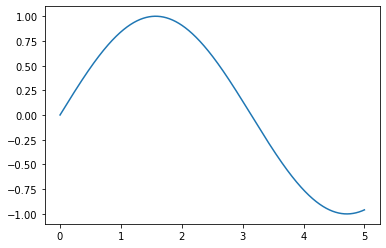

In [2]:
with nengo.Network() as net:

    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)

        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))

        return output

    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)

plt.figure()
plt.plot(sim.trange(), sim.data[p])
plt.show()

However, outputting a `sin` function is something we could do more easily with a regular
`nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more
complex TensorFlow code and insert it into a NengoDL model. For example, one thing we
often want to do is take a deep network written in TensorFlow/Keras, and add it into a
Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate) is a popular software
package for building and training deep learning style networks.  It is a higher-level
API within TensorFlow to make it easier to construct and train deep networks.  And
because it is all implemented as a TensorFlow network under the hood, we can define a
network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the
[introduction in the Tensorflow
documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are
not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.
This dataset contains images of clothing, and the goal of the network is to identify
what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

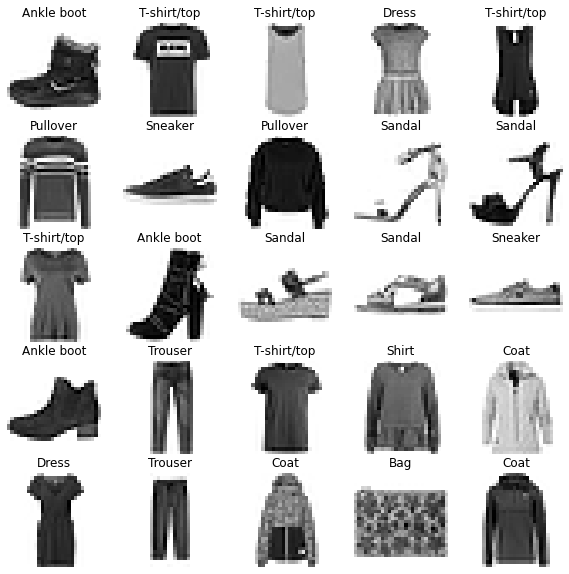

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.fashion_mnist.load_data()

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're
building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in
NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do
everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Epoch 1/5


   1/1875 [..............................] - ETA: 19:25 - loss: 2.2751 - accuracy: 0.0938

  32/1875 [..............................] - ETA: 3s - loss: 1.3212 - accuracy: 0.5449   

  62/1875 [..............................] - ETA: 3s - loss: 1.0899 - accuracy: 0.6190

  93/1875 [>.............................] - ETA: 2s - loss: 0.9479 - accuracy: 0.6670

 123/1875 [>.............................] - ETA: 2s - loss: 0.8763 - accuracy: 0.6926

 153/1875 [=>............................] - ETA: 2s - loss: 0.8231 - accuracy: 0.7106

 182/1875 [=>............................] - ETA: 2s - loss: 0.7921 - accuracy: 0.7212

 213/1875 [==>...........................] - ETA: 2s - loss: 0.7639 - accuracy: 0.7311

 241/1875 [==>...........................] - ETA: 2s - loss: 0.7413 - accuracy: 0.7407

 273/1875 [===>..........................] - ETA: 2s - loss: 0.7165 - accuracy: 0.7500

 305/1875 [===>..........................] - ETA: 2s - loss: 0.6994 - accuracy: 0.7544

 336/1875 [====>.........................] - ETA: 2s - loss: 0.6887 - accuracy: 0.7576

 368/1875 [====>.........................] - ETA: 2s - loss: 0.6755 - accuracy: 0.7624

 397/1875 [=====>........................] - ETA: 2s - loss: 0.6677 - accuracy: 0.7656

 429/1875 [=====>........................] - ETA: 2s - loss: 0.6565 - accuracy: 0.7699

 460/1875 [======>.......................] - ETA: 2s - loss: 0.6447 - accuracy: 0.7738

 491/1875 [======>.......................] - ETA: 2s - loss: 0.6378 - accuracy: 0.7765

 523/1875 [=======>......................] - ETA: 2s - loss: 0.6314 - accuracy: 0.7785

 554/1875 [=======>......................] - ETA: 2s - loss: 0.6229 - accuracy: 0.7816

 585/1875 [========>.....................] - ETA: 2s - loss: 0.6194 - accuracy: 0.7829

 614/1875 [========>.....................] - ETA: 2s - loss: 0.6139 - accuracy: 0.7845

 645/1875 [=========>....................] - ETA: 2s - loss: 0.6083 - accuracy: 0.7871

 676/1875 [=========>....................] - ETA: 1s - loss: 0.6008 - accuracy: 0.7901

 706/1875 [==========>...................] - ETA: 1s - loss: 0.5959 - accuracy: 0.7920

 738/1875 [==========>...................] - ETA: 1s - loss: 0.5904 - accuracy: 0.7934

 758/1875 [===========>..................] - ETA: 1s - loss: 0.5870 - accuracy: 0.7943

 789/1875 [===========>..................] - ETA: 1s - loss: 0.5829 - accuracy: 0.7952

 819/1875 [============>.................] - ETA: 1s - loss: 0.5794 - accuracy: 0.7960

 849/1875 [============>.................] - ETA: 1s - loss: 0.5774 - accuracy: 0.7966

 879/1875 [=============>................] - ETA: 1s - loss: 0.5740 - accuracy: 0.7982

 908/1875 [=============>................] - ETA: 1s - loss: 0.5696 - accuracy: 0.7998

 938/1875 [==============>...............] - ETA: 1s - loss: 0.5644 - accuracy: 0.8019

 966/1875 [==============>...............] - ETA: 1s - loss: 0.5617 - accuracy: 0.8029

 995/1875 [==============>...............] - ETA: 1s - loss: 0.5585 - accuracy: 0.8041

1025/1875 [===============>..............] - ETA: 1s - loss: 0.5543 - accuracy: 0.8054

1057/1875 [===============>..............] - ETA: 1s - loss: 0.5519 - accuracy: 0.8065

1087/1875 [================>.............] - ETA: 1s - loss: 0.5486 - accuracy: 0.8076

1118/1875 [================>.............] - ETA: 1s - loss: 0.5458 - accuracy: 0.8084

1149/1875 [=================>............] - ETA: 1s - loss: 0.5429 - accuracy: 0.8096

1180/1875 [=================>............] - ETA: 1s - loss: 0.5396 - accuracy: 0.8105

1208/1875 [==================>...........] - ETA: 1s - loss: 0.5367 - accuracy: 0.8114

1239/1875 [==================>...........] - ETA: 1s - loss: 0.5344 - accuracy: 0.8122

1270/1875 [===================>..........] - ETA: 1s - loss: 0.5325 - accuracy: 0.8130

1300/1875 [===================>..........] - ETA: 0s - loss: 0.5309 - accuracy: 0.8138

1332/1875 [====================>.........] - ETA: 0s - loss: 0.5287 - accuracy: 0.8147

1360/1875 [====================>.........] - ETA: 0s - loss: 0.5269 - accuracy: 0.8152

1392/1875 [=====================>........] - ETA: 0s - loss: 0.5242 - accuracy: 0.8162

1423/1875 [=====================>........] - ETA: 0s - loss: 0.5217 - accuracy: 0.8168

1454/1875 [======================>.......] - ETA: 0s - loss: 0.5193 - accuracy: 0.8178

1485/1875 [======================>.......] - ETA: 0s - loss: 0.5171 - accuracy: 0.8185

1516/1875 [=======================>......] - ETA: 0s - loss: 0.5151 - accuracy: 0.8194

1547/1875 [=======================>......] - ETA: 0s - loss: 0.5143 - accuracy: 0.8195

1578/1875 [========================>.....] - ETA: 0s - loss: 0.5129 - accuracy: 0.8199

1609/1875 [========================>.....] - ETA: 0s - loss: 0.5118 - accuracy: 0.8203

1641/1875 [=========================>....] - ETA: 0s - loss: 0.5095 - accuracy: 0.8210

1672/1875 [=========================>....] - ETA: 0s - loss: 0.5076 - accuracy: 0.8217

1699/1875 [==========================>...] - ETA: 0s - loss: 0.5072 - accuracy: 0.8220

1730/1875 [==========================>...] - ETA: 0s - loss: 0.5055 - accuracy: 0.8225

1762/1875 [===========================>..] - ETA: 0s - loss: 0.5029 - accuracy: 0.8235

1794/1875 [===========================>..] - ETA: 0s - loss: 0.5018 - accuracy: 0.8239

1825/1875 [============================>.] - ETA: 0s - loss: 0.5006 - accuracy: 0.8243

1855/1875 [============================>.] - ETA: 0s - loss: 0.5001 - accuracy: 0.8245

1875/1875 [==============================] - 4s 2ms/step - loss: 0.4992 - accuracy: 0.8246


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1635 - accuracy: 0.9688

  32/1875 [..............................] - ETA: 2s - loss: 0.3771 - accuracy: 0.8711

  63/1875 [>.............................] - ETA: 2s - loss: 0.3730 - accuracy: 0.8735

  91/1875 [>.............................] - ETA: 2s - loss: 0.3893 - accuracy: 0.8647

 122/1875 [>.............................] - ETA: 2s - loss: 0.3940 - accuracy: 0.8632

 153/1875 [=>............................] - ETA: 2s - loss: 0.3944 - accuracy: 0.8593

 184/1875 [=>............................] - ETA: 2s - loss: 0.3989 - accuracy: 0.8577

 211/1875 [==>...........................] - ETA: 2s - loss: 0.3898 - accuracy: 0.8614

 242/1875 [==>...........................] - ETA: 2s - loss: 0.3901 - accuracy: 0.8613

 274/1875 [===>..........................] - ETA: 2s - loss: 0.3931 - accuracy: 0.8589

 305/1875 [===>..........................] - ETA: 2s - loss: 0.3983 - accuracy: 0.8578

 335/1875 [====>.........................] - ETA: 2s - loss: 0.3950 - accuracy: 0.8583

 366/1875 [====>.........................] - ETA: 2s - loss: 0.3903 - accuracy: 0.8594

 398/1875 [=====>........................] - ETA: 2s - loss: 0.3877 - accuracy: 0.8591

 428/1875 [=====>........................] - ETA: 2s - loss: 0.3885 - accuracy: 0.8589

 459/1875 [======>.......................] - ETA: 2s - loss: 0.3871 - accuracy: 0.8594

 490/1875 [======>.......................] - ETA: 2s - loss: 0.3864 - accuracy: 0.8597

 521/1875 [=======>......................] - ETA: 2s - loss: 0.3874 - accuracy: 0.8596

 552/1875 [=======>......................] - ETA: 2s - loss: 0.3851 - accuracy: 0.8605

 583/1875 [========>.....................] - ETA: 2s - loss: 0.3856 - accuracy: 0.8599

 615/1875 [========>.....................] - ETA: 2s - loss: 0.3855 - accuracy: 0.8597

 645/1875 [=========>....................] - ETA: 2s - loss: 0.3860 - accuracy: 0.8594

 676/1875 [=========>....................] - ETA: 1s - loss: 0.3863 - accuracy: 0.8590

 705/1875 [==========>...................] - ETA: 1s - loss: 0.3856 - accuracy: 0.8590

 736/1875 [==========>...................] - ETA: 1s - loss: 0.3864 - accuracy: 0.8590

 767/1875 [===========>..................] - ETA: 1s - loss: 0.3863 - accuracy: 0.8591

 799/1875 [===========>..................] - ETA: 1s - loss: 0.3872 - accuracy: 0.8588

 830/1875 [============>.................] - ETA: 1s - loss: 0.3860 - accuracy: 0.8591

 860/1875 [============>.................] - ETA: 1s - loss: 0.3842 - accuracy: 0.8607

 891/1875 [=============>................] - ETA: 1s - loss: 0.3840 - accuracy: 0.8609

 922/1875 [=============>................] - ETA: 1s - loss: 0.3831 - accuracy: 0.8615

 953/1875 [==============>...............] - ETA: 1s - loss: 0.3821 - accuracy: 0.8614

 985/1875 [==============>...............] - ETA: 1s - loss: 0.3820 - accuracy: 0.8613

1017/1875 [===============>..............] - ETA: 1s - loss: 0.3817 - accuracy: 0.8611

1049/1875 [===============>..............] - ETA: 1s - loss: 0.3815 - accuracy: 0.8614

1080/1875 [================>.............] - ETA: 1s - loss: 0.3803 - accuracy: 0.8617

1111/1875 [================>.............] - ETA: 1s - loss: 0.3789 - accuracy: 0.8624

1142/1875 [=================>............] - ETA: 1s - loss: 0.3779 - accuracy: 0.8627

1173/1875 [=================>............] - ETA: 1s - loss: 0.3783 - accuracy: 0.8627

1201/1875 [==================>...........] - ETA: 1s - loss: 0.3783 - accuracy: 0.8628

1232/1875 [==================>...........] - ETA: 1s - loss: 0.3787 - accuracy: 0.8627

1263/1875 [===================>..........] - ETA: 1s - loss: 0.3789 - accuracy: 0.8628

1293/1875 [===================>..........] - ETA: 0s - loss: 0.3799 - accuracy: 0.8621

1323/1875 [====================>.........] - ETA: 0s - loss: 0.3805 - accuracy: 0.8618

1346/1875 [====================>.........] - ETA: 0s - loss: 0.3809 - accuracy: 0.8617

1375/1875 [=====================>........] - ETA: 0s - loss: 0.3800 - accuracy: 0.8621

1406/1875 [=====================>........] - ETA: 0s - loss: 0.3788 - accuracy: 0.8626

1436/1875 [=====================>........] - ETA: 0s - loss: 0.3793 - accuracy: 0.8625

1467/1875 [======================>.......] - ETA: 0s - loss: 0.3791 - accuracy: 0.8627

1498/1875 [======================>.......] - ETA: 0s - loss: 0.3793 - accuracy: 0.8626

1530/1875 [=======================>......] - ETA: 0s - loss: 0.3789 - accuracy: 0.8629

1561/1875 [=======================>......] - ETA: 0s - loss: 0.3794 - accuracy: 0.8628

1592/1875 [========================>.....] - ETA: 0s - loss: 0.3799 - accuracy: 0.8628

1623/1875 [========================>.....] - ETA: 0s - loss: 0.3791 - accuracy: 0.8630

1654/1875 [=========================>....] - ETA: 0s - loss: 0.3783 - accuracy: 0.8632

1683/1875 [=========================>....] - ETA: 0s - loss: 0.3781 - accuracy: 0.8634

1714/1875 [==========================>...] - ETA: 0s - loss: 0.3782 - accuracy: 0.8633

1745/1875 [==========================>...] - ETA: 0s - loss: 0.3779 - accuracy: 0.8634

1776/1875 [===========================>..] - ETA: 0s - loss: 0.3773 - accuracy: 0.8636

1807/1875 [===========================>..] - ETA: 0s - loss: 0.3770 - accuracy: 0.8637

1839/1875 [============================>.] - ETA: 0s - loss: 0.3763 - accuracy: 0.8640

1870/1875 [============================>.] - ETA: 0s - loss: 0.3757 - accuracy: 0.8645

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3758 - accuracy: 0.8644


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.4776 - accuracy: 0.8438

  31/1875 [..............................] - ETA: 3s - loss: 0.3343 - accuracy: 0.8700

  59/1875 [..............................] - ETA: 3s - loss: 0.3638 - accuracy: 0.8612

  90/1875 [>.............................] - ETA: 3s - loss: 0.3519 - accuracy: 0.8677

 112/1875 [>.............................] - ETA: 3s - loss: 0.3509 - accuracy: 0.8675

 141/1875 [=>............................] - ETA: 3s - loss: 0.3474 - accuracy: 0.8692

 167/1875 [=>............................] - ETA: 3s - loss: 0.3436 - accuracy: 0.8709

 198/1875 [==>...........................] - ETA: 3s - loss: 0.3392 - accuracy: 0.8737

 229/1875 [==>...........................] - ETA: 2s - loss: 0.3322 - accuracy: 0.8769

 260/1875 [===>..........................] - ETA: 2s - loss: 0.3336 - accuracy: 0.8757

 291/1875 [===>..........................] - ETA: 2s - loss: 0.3346 - accuracy: 0.8761

 323/1875 [====>.........................] - ETA: 2s - loss: 0.3344 - accuracy: 0.8757

 354/1875 [====>.........................] - ETA: 2s - loss: 0.3339 - accuracy: 0.8761

 385/1875 [=====>........................] - ETA: 2s - loss: 0.3327 - accuracy: 0.8767

 417/1875 [=====>........................] - ETA: 2s - loss: 0.3346 - accuracy: 0.8758

 445/1875 [======>.......................] - ETA: 2s - loss: 0.3333 - accuracy: 0.8757

 476/1875 [======>.......................] - ETA: 2s - loss: 0.3354 - accuracy: 0.8759

 507/1875 [=======>......................] - ETA: 2s - loss: 0.3372 - accuracy: 0.8751

 539/1875 [=======>......................] - ETA: 2s - loss: 0.3393 - accuracy: 0.8750

 570/1875 [========>.....................] - ETA: 2s - loss: 0.3369 - accuracy: 0.8766

 601/1875 [========>.....................] - ETA: 2s - loss: 0.3374 - accuracy: 0.8757

 632/1875 [=========>....................] - ETA: 2s - loss: 0.3381 - accuracy: 0.8756

 663/1875 [=========>....................] - ETA: 2s - loss: 0.3380 - accuracy: 0.8758

 694/1875 [==========>...................] - ETA: 1s - loss: 0.3393 - accuracy: 0.8751

 724/1875 [==========>...................] - ETA: 1s - loss: 0.3385 - accuracy: 0.8753

 755/1875 [===========>..................] - ETA: 1s - loss: 0.3400 - accuracy: 0.8743

 784/1875 [===========>..................] - ETA: 1s - loss: 0.3406 - accuracy: 0.8743

 814/1875 [============>.................] - ETA: 1s - loss: 0.3414 - accuracy: 0.8739

 845/1875 [============>.................] - ETA: 1s - loss: 0.3411 - accuracy: 0.8739

 876/1875 [=============>................] - ETA: 1s - loss: 0.3397 - accuracy: 0.8745

 907/1875 [=============>................] - ETA: 1s - loss: 0.3387 - accuracy: 0.8751

 938/1875 [==============>...............] - ETA: 1s - loss: 0.3385 - accuracy: 0.8751

 968/1875 [==============>...............] - ETA: 1s - loss: 0.3375 - accuracy: 0.8754

 999/1875 [==============>...............] - ETA: 1s - loss: 0.3379 - accuracy: 0.8752

1024/1875 [===============>..............] - ETA: 1s - loss: 0.3381 - accuracy: 0.8751

1055/1875 [===============>..............] - ETA: 1s - loss: 0.3373 - accuracy: 0.8757

1086/1875 [================>.............] - ETA: 1s - loss: 0.3375 - accuracy: 0.8757

1117/1875 [================>.............] - ETA: 1s - loss: 0.3373 - accuracy: 0.8756

1148/1875 [=================>............] - ETA: 1s - loss: 0.3370 - accuracy: 0.8759

1179/1875 [=================>............] - ETA: 1s - loss: 0.3372 - accuracy: 0.8758

1207/1875 [==================>...........] - ETA: 1s - loss: 0.3362 - accuracy: 0.8762

1238/1875 [==================>...........] - ETA: 1s - loss: 0.3353 - accuracy: 0.8768

1270/1875 [===================>..........] - ETA: 1s - loss: 0.3355 - accuracy: 0.8766

1300/1875 [===================>..........] - ETA: 0s - loss: 0.3347 - accuracy: 0.8768

1323/1875 [====================>.........] - ETA: 0s - loss: 0.3338 - accuracy: 0.8772

1354/1875 [====================>.........] - ETA: 0s - loss: 0.3351 - accuracy: 0.8769

1385/1875 [=====================>........] - ETA: 0s - loss: 0.3355 - accuracy: 0.8770

1416/1875 [=====================>........] - ETA: 0s - loss: 0.3360 - accuracy: 0.8768

1447/1875 [======================>.......] - ETA: 0s - loss: 0.3355 - accuracy: 0.8771

1478/1875 [======================>.......] - ETA: 0s - loss: 0.3357 - accuracy: 0.8769

1509/1875 [=======================>......] - ETA: 0s - loss: 0.3360 - accuracy: 0.8769

1535/1875 [=======================>......] - ETA: 0s - loss: 0.3368 - accuracy: 0.8768

1566/1875 [========================>.....] - ETA: 0s - loss: 0.3368 - accuracy: 0.8767

1597/1875 [========================>.....] - ETA: 0s - loss: 0.3371 - accuracy: 0.8766

1620/1875 [========================>.....] - ETA: 0s - loss: 0.3370 - accuracy: 0.8767

1651/1875 [=========================>....] - ETA: 0s - loss: 0.3378 - accuracy: 0.8765

1681/1875 [=========================>....] - ETA: 0s - loss: 0.3369 - accuracy: 0.8768

1712/1875 [==========================>...] - ETA: 0s - loss: 0.3367 - accuracy: 0.8766

1740/1875 [==========================>...] - ETA: 0s - loss: 0.3376 - accuracy: 0.8763

1771/1875 [===========================>..] - ETA: 0s - loss: 0.3368 - accuracy: 0.8766

1801/1875 [===========================>..] - ETA: 0s - loss: 0.3364 - accuracy: 0.8767

1832/1875 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8771

1863/1875 [============================>.] - ETA: 0s - loss: 0.3365 - accuracy: 0.8768

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3363 - accuracy: 0.8770


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1855 - accuracy: 0.9062

  32/1875 [..............................] - ETA: 3s - loss: 0.3324 - accuracy: 0.8721

  63/1875 [>.............................] - ETA: 2s - loss: 0.3396 - accuracy: 0.8715

  94/1875 [>.............................] - ETA: 2s - loss: 0.3315 - accuracy: 0.8763

 124/1875 [>.............................] - ETA: 2s - loss: 0.3186 - accuracy: 0.8808

 155/1875 [=>............................] - ETA: 2s - loss: 0.3082 - accuracy: 0.8859

 187/1875 [=>............................] - ETA: 2s - loss: 0.3179 - accuracy: 0.8810

 218/1875 [==>...........................] - ETA: 2s - loss: 0.3125 - accuracy: 0.8829

 250/1875 [===>..........................] - ETA: 2s - loss: 0.3123 - accuracy: 0.8827

 281/1875 [===>..........................] - ETA: 2s - loss: 0.3115 - accuracy: 0.8838

 312/1875 [===>..........................] - ETA: 2s - loss: 0.3152 - accuracy: 0.8829

 343/1875 [====>.........................] - ETA: 2s - loss: 0.3164 - accuracy: 0.8830

 374/1875 [====>.........................] - ETA: 2s - loss: 0.3151 - accuracy: 0.8829

 405/1875 [=====>........................] - ETA: 2s - loss: 0.3148 - accuracy: 0.8833

 436/1875 [=====>........................] - ETA: 2s - loss: 0.3124 - accuracy: 0.8853

 467/1875 [======>.......................] - ETA: 2s - loss: 0.3137 - accuracy: 0.8852

 498/1875 [======>.......................] - ETA: 2s - loss: 0.3128 - accuracy: 0.8857

 528/1875 [=======>......................] - ETA: 2s - loss: 0.3110 - accuracy: 0.8860

 559/1875 [=======>......................] - ETA: 2s - loss: 0.3108 - accuracy: 0.8864

 590/1875 [========>.....................] - ETA: 2s - loss: 0.3103 - accuracy: 0.8864

 618/1875 [========>.....................] - ETA: 2s - loss: 0.3115 - accuracy: 0.8857

 649/1875 [=========>....................] - ETA: 2s - loss: 0.3113 - accuracy: 0.8856

 679/1875 [=========>....................] - ETA: 1s - loss: 0.3124 - accuracy: 0.8851

 707/1875 [==========>...................] - ETA: 1s - loss: 0.3125 - accuracy: 0.8849

 738/1875 [==========>...................] - ETA: 1s - loss: 0.3113 - accuracy: 0.8857

 754/1875 [===========>..................] - ETA: 1s - loss: 0.3109 - accuracy: 0.8858

 766/1875 [===========>..................] - ETA: 1s - loss: 0.3105 - accuracy: 0.8858

 793/1875 [===========>..................] - ETA: 1s - loss: 0.3093 - accuracy: 0.8862

 821/1875 [============>.................] - ETA: 1s - loss: 0.3082 - accuracy: 0.8866

 847/1875 [============>.................] - ETA: 1s - loss: 0.3080 - accuracy: 0.8868

 879/1875 [=============>................] - ETA: 1s - loss: 0.3094 - accuracy: 0.8861

 911/1875 [=============>................] - ETA: 1s - loss: 0.3087 - accuracy: 0.8866

 942/1875 [==============>...............] - ETA: 1s - loss: 0.3089 - accuracy: 0.8860

 972/1875 [==============>...............] - ETA: 1s - loss: 0.3090 - accuracy: 0.8862

1003/1875 [===============>..............] - ETA: 1s - loss: 0.3091 - accuracy: 0.8866

1035/1875 [===============>..............] - ETA: 1s - loss: 0.3094 - accuracy: 0.8867

1066/1875 [================>.............] - ETA: 1s - loss: 0.3106 - accuracy: 0.8861

1097/1875 [================>.............] - ETA: 1s - loss: 0.3106 - accuracy: 0.8864

1129/1875 [=================>............] - ETA: 1s - loss: 0.3100 - accuracy: 0.8867

1160/1875 [=================>............] - ETA: 1s - loss: 0.3107 - accuracy: 0.8863

1191/1875 [==================>...........] - ETA: 1s - loss: 0.3106 - accuracy: 0.8863

1222/1875 [==================>...........] - ETA: 1s - loss: 0.3104 - accuracy: 0.8861

1253/1875 [===================>..........] - ETA: 1s - loss: 0.3104 - accuracy: 0.8861

1284/1875 [===================>..........] - ETA: 1s - loss: 0.3105 - accuracy: 0.8859

1314/1875 [====================>.........] - ETA: 0s - loss: 0.3103 - accuracy: 0.8860

1345/1875 [====================>.........] - ETA: 0s - loss: 0.3102 - accuracy: 0.8860

1376/1875 [=====================>........] - ETA: 0s - loss: 0.3107 - accuracy: 0.8860

1408/1875 [=====================>........] - ETA: 0s - loss: 0.3098 - accuracy: 0.8864

1439/1875 [======================>.......] - ETA: 0s - loss: 0.3104 - accuracy: 0.8862

1470/1875 [======================>.......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8861

1501/1875 [=======================>......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8860

1532/1875 [=======================>......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8858

1562/1875 [=======================>......] - ETA: 0s - loss: 0.3109 - accuracy: 0.8857

1592/1875 [========================>.....] - ETA: 0s - loss: 0.3111 - accuracy: 0.8858

1623/1875 [========================>.....] - ETA: 0s - loss: 0.3114 - accuracy: 0.8854

1655/1875 [=========================>....] - ETA: 0s - loss: 0.3113 - accuracy: 0.8855

1685/1875 [=========================>....] - ETA: 0s - loss: 0.3105 - accuracy: 0.8858

1716/1875 [==========================>...] - ETA: 0s - loss: 0.3103 - accuracy: 0.8860

1747/1875 [==========================>...] - ETA: 0s - loss: 0.3100 - accuracy: 0.8862

1778/1875 [===========================>..] - ETA: 0s - loss: 0.3105 - accuracy: 0.8861

1809/1875 [===========================>..] - ETA: 0s - loss: 0.3119 - accuracy: 0.8855

1841/1875 [============================>.] - ETA: 0s - loss: 0.3125 - accuracy: 0.8854

1873/1875 [============================>.] - ETA: 0s - loss: 0.3125 - accuracy: 0.8852

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3124 - accuracy: 0.8852


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.2243 - accuracy: 0.9375

  33/1875 [..............................] - ETA: 2s - loss: 0.3135 - accuracy: 0.8769

  65/1875 [>.............................] - ETA: 2s - loss: 0.2803 - accuracy: 0.8904

  96/1875 [>.............................] - ETA: 2s - loss: 0.2644 - accuracy: 0.9007

 127/1875 [=>............................] - ETA: 2s - loss: 0.2703 - accuracy: 0.8969

 159/1875 [=>............................] - ETA: 2s - loss: 0.2796 - accuracy: 0.8935

 190/1875 [==>...........................] - ETA: 2s - loss: 0.2808 - accuracy: 0.8951

 222/1875 [==>...........................] - ETA: 2s - loss: 0.2843 - accuracy: 0.8957

 253/1875 [===>..........................] - ETA: 2s - loss: 0.2855 - accuracy: 0.8951

 284/1875 [===>..........................] - ETA: 2s - loss: 0.2859 - accuracy: 0.8946

 316/1875 [====>.........................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8938

 347/1875 [====>.........................] - ETA: 2s - loss: 0.2895 - accuracy: 0.8932

 378/1875 [=====>........................] - ETA: 2s - loss: 0.2892 - accuracy: 0.8942

 409/1875 [=====>........................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8943

 439/1875 [======>.......................] - ETA: 2s - loss: 0.2871 - accuracy: 0.8949

 470/1875 [======>.......................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8941

 501/1875 [=======>......................] - ETA: 2s - loss: 0.2853 - accuracy: 0.8950

 533/1875 [=======>......................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8946

 565/1875 [========>.....................] - ETA: 2s - loss: 0.2897 - accuracy: 0.8937

 596/1875 [========>.....................] - ETA: 2s - loss: 0.2909 - accuracy: 0.8931

 627/1875 [=========>....................] - ETA: 2s - loss: 0.2929 - accuracy: 0.8926

 659/1875 [=========>....................] - ETA: 1s - loss: 0.2948 - accuracy: 0.8917

 690/1875 [==========>...................] - ETA: 1s - loss: 0.2932 - accuracy: 0.8926

 721/1875 [==========>...................] - ETA: 1s - loss: 0.2925 - accuracy: 0.8926

 751/1875 [===========>..................] - ETA: 1s - loss: 0.2934 - accuracy: 0.8922

 782/1875 [===========>..................] - ETA: 1s - loss: 0.2940 - accuracy: 0.8919

 812/1875 [===========>..................] - ETA: 1s - loss: 0.2926 - accuracy: 0.8925

 843/1875 [============>.................] - ETA: 1s - loss: 0.2919 - accuracy: 0.8927

 874/1875 [============>.................] - ETA: 1s - loss: 0.2924 - accuracy: 0.8924

 905/1875 [=============>................] - ETA: 1s - loss: 0.2934 - accuracy: 0.8919

 936/1875 [=============>................] - ETA: 1s - loss: 0.2944 - accuracy: 0.8916

 967/1875 [==============>...............] - ETA: 1s - loss: 0.2944 - accuracy: 0.8917

 998/1875 [==============>...............] - ETA: 1s - loss: 0.2938 - accuracy: 0.8916

1029/1875 [===============>..............] - ETA: 1s - loss: 0.2926 - accuracy: 0.8921

1057/1875 [===============>..............] - ETA: 1s - loss: 0.2916 - accuracy: 0.8923

1088/1875 [================>.............] - ETA: 1s - loss: 0.2914 - accuracy: 0.8925

1119/1875 [================>.............] - ETA: 1s - loss: 0.2910 - accuracy: 0.8924

1151/1875 [=================>............] - ETA: 1s - loss: 0.2908 - accuracy: 0.8926

1182/1875 [=================>............] - ETA: 1s - loss: 0.2901 - accuracy: 0.8927

1212/1875 [==================>...........] - ETA: 1s - loss: 0.2903 - accuracy: 0.8926

1243/1875 [==================>...........] - ETA: 1s - loss: 0.2917 - accuracy: 0.8919

1271/1875 [===================>..........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8918

1301/1875 [===================>..........] - ETA: 0s - loss: 0.2913 - accuracy: 0.8919

1333/1875 [====================>.........] - ETA: 0s - loss: 0.2912 - accuracy: 0.8918

1345/1875 [====================>.........] - ETA: 0s - loss: 0.2913 - accuracy: 0.8918

1375/1875 [=====================>........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8918

1406/1875 [=====================>........] - ETA: 0s - loss: 0.2922 - accuracy: 0.8914

1437/1875 [=====================>........] - ETA: 0s - loss: 0.2925 - accuracy: 0.8914

1468/1875 [======================>.......] - ETA: 0s - loss: 0.2934 - accuracy: 0.8909

1500/1875 [=======================>......] - ETA: 0s - loss: 0.2945 - accuracy: 0.8906

1531/1875 [=======================>......] - ETA: 0s - loss: 0.2947 - accuracy: 0.8903

1562/1875 [=======================>......] - ETA: 0s - loss: 0.2939 - accuracy: 0.8906

1592/1875 [========================>.....] - ETA: 0s - loss: 0.2938 - accuracy: 0.8906

1620/1875 [========================>.....] - ETA: 0s - loss: 0.2933 - accuracy: 0.8907

1651/1875 [=========================>....] - ETA: 0s - loss: 0.2934 - accuracy: 0.8908

1682/1875 [=========================>....] - ETA: 0s - loss: 0.2932 - accuracy: 0.8909

1713/1875 [==========================>...] - ETA: 0s - loss: 0.2935 - accuracy: 0.8910

1744/1875 [==========================>...] - ETA: 0s - loss: 0.2937 - accuracy: 0.8910

1775/1875 [===========================>..] - ETA: 0s - loss: 0.2935 - accuracy: 0.8911

1805/1875 [===========================>..] - ETA: 0s - loss: 0.2934 - accuracy: 0.8911

1836/1875 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8913

1867/1875 [============================>.] - ETA: 0s - loss: 0.2932 - accuracy: 0.8911

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2933 - accuracy: 0.8911


Test accuracy: 0.871999979019165


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more
complicated in this case, since we need to load in the model from above and the
pretrained weights.  We can accomplish this by creating a custom Keras Layer, which
allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This
effectively reruns the Keras model definition from above, but because we're calling it
within the `build` stage it will be naturally integrated into the NengoDL model that is
being built.

The `call` function is where we do the main job of constructing the TensorFlow elements
that will implement our node.  It will take TensorFlow Tensors as input and produce a
`tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the
Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement
that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()

        self.model = keras_model

    def build(self, input_shapes):
        super().build(input_shapes)

        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)

        # load the weights we saved above
        self.model.load_weights(model_weights)

    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into
a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in
our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)

    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28 * 28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and
connect them up to the Keras node (for example, if we wanted to take the classified
image labels and use them as input to a spiking neural model).  But to keep things
simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully
loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
with net:
    # we'll disable some features we don't need in this example, to improve
    # the training speed
    nengo_dl.configure_settings(stateful=False, use_loop=False)

minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.871999979019165


We can see that we're getting the same performance in Nengo as we were in Keras,
indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to
integrate a Keras model into Nengo by inserting the individual layers.  This requires
more manual translation work, but it makes it easier to make changes to the model later
on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this
time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to
the TensorNode.  However, we can make this construction process even simpler by using
`nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the
Keras functional layer API. Under the hood it's doing the same thing (creating
TensorNodes and Connections), but it allows us to define the model in a way that looks
very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(
        inp
    )
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL
this time. Fortunately, the API is essentially the same:

In [11]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 19:44 - loss: 2.2471 - probe_loss: 2.2471 - probe_accuracy: 0.1000

  28/3000 [..............................] - ETA: 5s - loss: 1.3777 - probe_loss: 1.3777 - probe_accuracy: 0.5018   

  56/3000 [..............................] - ETA: 5s - loss: 1.1523 - probe_loss: 1.1523 - probe_accuracy: 0.5857

  83/3000 [..............................] - ETA: 5s - loss: 1.0377 - probe_loss: 1.0377 - probe_accuracy: 0.6361

 111/3000 [>.............................] - ETA: 5s - loss: 0.9611 - probe_loss: 0.9611 - probe_accuracy: 0.6622

 139/3000 [>.............................] - ETA: 5s - loss: 0.8931 - probe_loss: 0.8931 - probe_accuracy: 0.6845

 167/3000 [>.............................] - ETA: 5s - loss: 0.8593 - probe_loss: 0.8593 - probe_accuracy: 0.6982

 195/3000 [>.............................] - ETA: 5s - loss: 0.8367 - probe_loss: 0.8367 - probe_accuracy: 0.7067

 223/3000 [=>............................] - ETA: 5s - loss: 0.8188 - probe_loss: 0.8188 - probe_accuracy: 0.7135

 251/3000 [=>............................] - ETA: 5s - loss: 0.7979 - probe_loss: 0.7979 - probe_accuracy: 0.7189

 279/3000 [=>............................] - ETA: 4s - loss: 0.7820 - probe_loss: 0.7820 - probe_accuracy: 0.7281

 307/3000 [==>...........................] - ETA: 4s - loss: 0.7751 - probe_loss: 0.7751 - probe_accuracy: 0.7321

 332/3000 [==>...........................] - ETA: 4s - loss: 0.7504 - probe_loss: 0.7504 - probe_accuracy: 0.7405

 353/3000 [==>...........................] - ETA: 4s - loss: 0.7435 - probe_loss: 0.7435 - probe_accuracy: 0.7429

 381/3000 [==>...........................] - ETA: 4s - loss: 0.7312 - probe_loss: 0.7312 - probe_accuracy: 0.7470

 399/3000 [==>...........................] - ETA: 4s - loss: 0.7231 - probe_loss: 0.7231 - probe_accuracy: 0.7499

 427/3000 [===>..........................] - ETA: 4s - loss: 0.7117 - probe_loss: 0.7117 - probe_accuracy: 0.7541

 455/3000 [===>..........................] - ETA: 4s - loss: 0.7015 - probe_loss: 0.7015 - probe_accuracy: 0.7574

 482/3000 [===>..........................] - ETA: 4s - loss: 0.6874 - probe_loss: 0.6874 - probe_accuracy: 0.7611

 509/3000 [====>.........................] - ETA: 4s - loss: 0.6806 - probe_loss: 0.6806 - probe_accuracy: 0.7640

 534/3000 [====>.........................] - ETA: 4s - loss: 0.6720 - probe_loss: 0.6720 - probe_accuracy: 0.7680

 562/3000 [====>.........................] - ETA: 4s - loss: 0.6667 - probe_loss: 0.6667 - probe_accuracy: 0.7701

 590/3000 [====>.........................] - ETA: 4s - loss: 0.6587 - probe_loss: 0.6587 - probe_accuracy: 0.7731

 618/3000 [=====>........................] - ETA: 4s - loss: 0.6550 - probe_loss: 0.6550 - probe_accuracy: 0.7745

 646/3000 [=====>........................] - ETA: 4s - loss: 0.6518 - probe_loss: 0.6518 - probe_accuracy: 0.7755

 674/3000 [=====>........................] - ETA: 4s - loss: 0.6484 - probe_loss: 0.6484 - probe_accuracy: 0.7765

 701/3000 [======>.......................] - ETA: 4s - loss: 0.6424 - probe_loss: 0.6424 - probe_accuracy: 0.7787

 729/3000 [======>.......................] - ETA: 4s - loss: 0.6362 - probe_loss: 0.6362 - probe_accuracy: 0.7809

 756/3000 [======>.......................] - ETA: 4s - loss: 0.6311 - probe_loss: 0.6311 - probe_accuracy: 0.7831

 783/3000 [======>.......................] - ETA: 4s - loss: 0.6259 - probe_loss: 0.6259 - probe_accuracy: 0.7852

 811/3000 [=======>......................] - ETA: 4s - loss: 0.6220 - probe_loss: 0.6220 - probe_accuracy: 0.7867

 839/3000 [=======>......................] - ETA: 4s - loss: 0.6191 - probe_loss: 0.6191 - probe_accuracy: 0.7876

 867/3000 [=======>......................] - ETA: 4s - loss: 0.6138 - probe_loss: 0.6138 - probe_accuracy: 0.7891

 895/3000 [=======>......................] - ETA: 3s - loss: 0.6113 - probe_loss: 0.6113 - probe_accuracy: 0.7897

 923/3000 [========>.....................] - ETA: 3s - loss: 0.6097 - probe_loss: 0.6097 - probe_accuracy: 0.7903

 950/3000 [========>.....................] - ETA: 3s - loss: 0.6068 - probe_loss: 0.6068 - probe_accuracy: 0.7912

 975/3000 [========>.....................] - ETA: 3s - loss: 0.6040 - probe_loss: 0.6040 - probe_accuracy: 0.7923

1002/3000 [=========>....................] - ETA: 3s - loss: 0.5997 - probe_loss: 0.5997 - probe_accuracy: 0.7937

1030/3000 [=========>....................] - ETA: 3s - loss: 0.5947 - probe_loss: 0.5947 - probe_accuracy: 0.7951

1058/3000 [=========>....................] - ETA: 3s - loss: 0.5927 - probe_loss: 0.5927 - probe_accuracy: 0.7957

1086/3000 [=========>....................] - ETA: 3s - loss: 0.5883 - probe_loss: 0.5883 - probe_accuracy: 0.7970

1114/3000 [==========>...................] - ETA: 3s - loss: 0.5848 - probe_loss: 0.5848 - probe_accuracy: 0.7979

1141/3000 [==========>...................] - ETA: 3s - loss: 0.5833 - probe_loss: 0.5833 - probe_accuracy: 0.7984

1169/3000 [==========>...................] - ETA: 3s - loss: 0.5800 - probe_loss: 0.5800 - probe_accuracy: 0.7997

1197/3000 [==========>...................] - ETA: 3s - loss: 0.5766 - probe_loss: 0.5766 - probe_accuracy: 0.8009

1221/3000 [===========>..................] - ETA: 3s - loss: 0.5744 - probe_loss: 0.5744 - probe_accuracy: 0.8015

1248/3000 [===========>..................] - ETA: 3s - loss: 0.5716 - probe_loss: 0.5716 - probe_accuracy: 0.8020

1275/3000 [===========>..................] - ETA: 3s - loss: 0.5701 - probe_loss: 0.5701 - probe_accuracy: 0.8025

1302/3000 [============>.................] - ETA: 3s - loss: 0.5667 - probe_loss: 0.5667 - probe_accuracy: 0.8036

1328/3000 [============>.................] - ETA: 3s - loss: 0.5649 - probe_loss: 0.5649 - probe_accuracy: 0.8039

1356/3000 [============>.................] - ETA: 3s - loss: 0.5625 - probe_loss: 0.5625 - probe_accuracy: 0.8047

1381/3000 [============>.................] - ETA: 3s - loss: 0.5606 - probe_loss: 0.5606 - probe_accuracy: 0.8054

1408/3000 [=============>................] - ETA: 2s - loss: 0.5584 - probe_loss: 0.5584 - probe_accuracy: 0.8058

1436/3000 [=============>................] - ETA: 2s - loss: 0.5580 - probe_loss: 0.5580 - probe_accuracy: 0.8057

1464/3000 [=============>................] - ETA: 2s - loss: 0.5570 - probe_loss: 0.5570 - probe_accuracy: 0.8061

1492/3000 [=============>................] - ETA: 2s - loss: 0.5555 - probe_loss: 0.5555 - probe_accuracy: 0.8068

1520/3000 [==============>...............] - ETA: 2s - loss: 0.5552 - probe_loss: 0.5552 - probe_accuracy: 0.8069

1546/3000 [==============>...............] - ETA: 2s - loss: 0.5529 - probe_loss: 0.5529 - probe_accuracy: 0.8076

1573/3000 [==============>...............] - ETA: 2s - loss: 0.5501 - probe_loss: 0.5501 - probe_accuracy: 0.8086

1600/3000 [===============>..............] - ETA: 2s - loss: 0.5481 - probe_loss: 0.5481 - probe_accuracy: 0.8094

1628/3000 [===============>..............] - ETA: 2s - loss: 0.5461 - probe_loss: 0.5461 - probe_accuracy: 0.8101

1656/3000 [===============>..............] - ETA: 2s - loss: 0.5438 - probe_loss: 0.5438 - probe_accuracy: 0.8108

1684/3000 [===============>..............] - ETA: 2s - loss: 0.5417 - probe_loss: 0.5417 - probe_accuracy: 0.8110

1712/3000 [================>.............] - ETA: 2s - loss: 0.5403 - probe_loss: 0.5403 - probe_accuracy: 0.8116

1740/3000 [================>.............] - ETA: 2s - loss: 0.5384 - probe_loss: 0.5384 - probe_accuracy: 0.8121

1768/3000 [================>.............] - ETA: 2s - loss: 0.5378 - probe_loss: 0.5378 - probe_accuracy: 0.8124

1795/3000 [================>.............] - ETA: 2s - loss: 0.5366 - probe_loss: 0.5366 - probe_accuracy: 0.8128

1822/3000 [=================>............] - ETA: 2s - loss: 0.5349 - probe_loss: 0.5349 - probe_accuracy: 0.8133

1849/3000 [=================>............] - ETA: 2s - loss: 0.5326 - probe_loss: 0.5326 - probe_accuracy: 0.8143

1876/3000 [=================>............] - ETA: 2s - loss: 0.5317 - probe_loss: 0.5317 - probe_accuracy: 0.8146

1904/3000 [==================>...........] - ETA: 2s - loss: 0.5299 - probe_loss: 0.5299 - probe_accuracy: 0.8153

1932/3000 [==================>...........] - ETA: 2s - loss: 0.5285 - probe_loss: 0.5285 - probe_accuracy: 0.8156

1960/3000 [==================>...........] - ETA: 1s - loss: 0.5270 - probe_loss: 0.5270 - probe_accuracy: 0.8160

1988/3000 [==================>...........] - ETA: 1s - loss: 0.5247 - probe_loss: 0.5247 - probe_accuracy: 0.8167

2016/3000 [===================>..........] - ETA: 1s - loss: 0.5235 - probe_loss: 0.5235 - probe_accuracy: 0.8171

2043/3000 [===================>..........] - ETA: 1s - loss: 0.5220 - probe_loss: 0.5220 - probe_accuracy: 0.8174

2071/3000 [===================>..........] - ETA: 1s - loss: 0.5206 - probe_loss: 0.5206 - probe_accuracy: 0.8180

2098/3000 [===================>..........] - ETA: 1s - loss: 0.5191 - probe_loss: 0.5191 - probe_accuracy: 0.8184

2125/3000 [====================>.........] - ETA: 1s - loss: 0.5186 - probe_loss: 0.5186 - probe_accuracy: 0.8186

2152/3000 [====================>.........] - ETA: 1s - loss: 0.5169 - probe_loss: 0.5169 - probe_accuracy: 0.8192

2177/3000 [====================>.........] - ETA: 1s - loss: 0.5162 - probe_loss: 0.5162 - probe_accuracy: 0.8194

2202/3000 [=====================>........] - ETA: 1s - loss: 0.5146 - probe_loss: 0.5146 - probe_accuracy: 0.8198

2230/3000 [=====================>........] - ETA: 1s - loss: 0.5136 - probe_loss: 0.5136 - probe_accuracy: 0.8200

2258/3000 [=====================>........] - ETA: 1s - loss: 0.5126 - probe_loss: 0.5126 - probe_accuracy: 0.8201

2286/3000 [=====================>........] - ETA: 1s - loss: 0.5117 - probe_loss: 0.5117 - probe_accuracy: 0.8205

2314/3000 [======================>.......] - ETA: 1s - loss: 0.5110 - probe_loss: 0.5110 - probe_accuracy: 0.8207

2343/3000 [======================>.......] - ETA: 1s - loss: 0.5097 - probe_loss: 0.5097 - probe_accuracy: 0.8210

2371/3000 [======================>.......] - ETA: 1s - loss: 0.5083 - probe_loss: 0.5083 - probe_accuracy: 0.8213

2400/3000 [=======================>......] - ETA: 1s - loss: 0.5071 - probe_loss: 0.5071 - probe_accuracy: 0.8220

2427/3000 [=======================>......] - ETA: 1s - loss: 0.5059 - probe_loss: 0.5059 - probe_accuracy: 0.8226

2449/3000 [=======================>......] - ETA: 1s - loss: 0.5044 - probe_loss: 0.5044 - probe_accuracy: 0.8231

2477/3000 [=======================>......] - ETA: 0s - loss: 0.5037 - probe_loss: 0.5037 - probe_accuracy: 0.8232

2505/3000 [========================>.....] - ETA: 0s - loss: 0.5025 - probe_loss: 0.5025 - probe_accuracy: 0.8234

2533/3000 [========================>.....] - ETA: 0s - loss: 0.5032 - probe_loss: 0.5032 - probe_accuracy: 0.8232

2560/3000 [========================>.....] - ETA: 0s - loss: 0.5025 - probe_loss: 0.5025 - probe_accuracy: 0.8234

2588/3000 [========================>.....] - ETA: 0s - loss: 0.5018 - probe_loss: 0.5018 - probe_accuracy: 0.8237

2616/3000 [=========================>....] - ETA: 0s - loss: 0.5011 - probe_loss: 0.5011 - probe_accuracy: 0.8239

2642/3000 [=========================>....] - ETA: 0s - loss: 0.4997 - probe_loss: 0.4997 - probe_accuracy: 0.8243

2670/3000 [=========================>....] - ETA: 0s - loss: 0.4984 - probe_loss: 0.4984 - probe_accuracy: 0.8246

2699/3000 [=========================>....] - ETA: 0s - loss: 0.4970 - probe_loss: 0.4970 - probe_accuracy: 0.8250

2726/3000 [==========================>...] - ETA: 0s - loss: 0.4962 - probe_loss: 0.4962 - probe_accuracy: 0.8253

2754/3000 [==========================>...] - ETA: 0s - loss: 0.4948 - probe_loss: 0.4948 - probe_accuracy: 0.8257

2782/3000 [==========================>...] - ETA: 0s - loss: 0.4940 - probe_loss: 0.4940 - probe_accuracy: 0.8258

2810/3000 [===========================>..] - ETA: 0s - loss: 0.4934 - probe_loss: 0.4934 - probe_accuracy: 0.8261

2837/3000 [===========================>..] - ETA: 0s - loss: 0.4924 - probe_loss: 0.4924 - probe_accuracy: 0.8263

2860/3000 [===========================>..] - ETA: 0s - loss: 0.4911 - probe_loss: 0.4911 - probe_accuracy: 0.8268

2887/3000 [===========================>..] - ETA: 0s - loss: 0.4901 - probe_loss: 0.4901 - probe_accuracy: 0.8272

2915/3000 [============================>.] - ETA: 0s - loss: 0.4892 - probe_loss: 0.4892 - probe_accuracy: 0.8276

2941/3000 [============================>.] - ETA: 0s - loss: 0.4882 - probe_loss: 0.4882 - probe_accuracy: 0.8278

2969/3000 [============================>.] - ETA: 0s - loss: 0.4874 - probe_loss: 0.4874 - probe_accuracy: 0.8281

2997/3000 [============================>.] - ETA: 0s - loss: 0.4869 - probe_loss: 0.4869 - probe_accuracy: 0.8283

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4867 - probe_loss: 0.4867 - probe_accuracy: 0.8284


Epoch 2/5
   1/3000 [..............................] - ETA: 6s - loss: 0.5185 - probe_loss: 0.5185 - probe_accuracy: 0.8000

  29/3000 [..............................] - ETA: 5s - loss: 0.4775 - probe_loss: 0.4775 - probe_accuracy: 0.8190

  57/3000 [..............................] - ETA: 5s - loss: 0.4237 - probe_loss: 0.4237 - probe_accuracy: 0.8474

  85/3000 [..............................] - ETA: 5s - loss: 0.4089 - probe_loss: 0.4089 - probe_accuracy: 0.8535

 108/3000 [>.............................] - ETA: 5s - loss: 0.4081 - probe_loss: 0.4081 - probe_accuracy: 0.8505

 136/3000 [>.............................] - ETA: 5s - loss: 0.4154 - probe_loss: 0.4154 - probe_accuracy: 0.8485

 163/3000 [>.............................] - ETA: 5s - loss: 0.4209 - probe_loss: 0.4209 - probe_accuracy: 0.8460

 191/3000 [>.............................] - ETA: 5s - loss: 0.4158 - probe_loss: 0.4158 - probe_accuracy: 0.8482

 218/3000 [=>............................] - ETA: 5s - loss: 0.4054 - probe_loss: 0.4054 - probe_accuracy: 0.8534

 246/3000 [=>............................] - ETA: 5s - loss: 0.4015 - probe_loss: 0.4015 - probe_accuracy: 0.8545

 273/3000 [=>............................] - ETA: 5s - loss: 0.3931 - probe_loss: 0.3931 - probe_accuracy: 0.8577

 301/3000 [==>...........................] - ETA: 5s - loss: 0.3846 - probe_loss: 0.3846 - probe_accuracy: 0.8598

 328/3000 [==>...........................] - ETA: 4s - loss: 0.3879 - probe_loss: 0.3879 - probe_accuracy: 0.8591

 356/3000 [==>...........................] - ETA: 4s - loss: 0.3880 - probe_loss: 0.3880 - probe_accuracy: 0.8577

 384/3000 [==>...........................] - ETA: 4s - loss: 0.3895 - probe_loss: 0.3895 - probe_accuracy: 0.8576

 412/3000 [===>..........................] - ETA: 4s - loss: 0.3897 - probe_loss: 0.3897 - probe_accuracy: 0.8583

 440/3000 [===>..........................] - ETA: 4s - loss: 0.3867 - probe_loss: 0.3867 - probe_accuracy: 0.8591

 468/3000 [===>..........................] - ETA: 4s - loss: 0.3855 - probe_loss: 0.3855 - probe_accuracy: 0.8595

 496/3000 [===>..........................] - ETA: 4s - loss: 0.3868 - probe_loss: 0.3868 - probe_accuracy: 0.8599

 523/3000 [====>.........................] - ETA: 4s - loss: 0.3874 - probe_loss: 0.3874 - probe_accuracy: 0.8590

 551/3000 [====>.........................] - ETA: 4s - loss: 0.3886 - probe_loss: 0.3886 - probe_accuracy: 0.8580

 576/3000 [====>.........................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8576

 599/3000 [====>.........................] - ETA: 4s - loss: 0.3881 - probe_loss: 0.3881 - probe_accuracy: 0.8570

 624/3000 [=====>........................] - ETA: 4s - loss: 0.3863 - probe_loss: 0.3863 - probe_accuracy: 0.8579

 648/3000 [=====>........................] - ETA: 4s - loss: 0.3848 - probe_loss: 0.3848 - probe_accuracy: 0.8588

 673/3000 [=====>........................] - ETA: 4s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8591

 698/3000 [=====>........................] - ETA: 4s - loss: 0.3843 - probe_loss: 0.3843 - probe_accuracy: 0.8599

 721/3000 [======>.......................] - ETA: 4s - loss: 0.3850 - probe_loss: 0.3850 - probe_accuracy: 0.8598

 747/3000 [======>.......................] - ETA: 4s - loss: 0.3845 - probe_loss: 0.3845 - probe_accuracy: 0.8603

 769/3000 [======>.......................] - ETA: 4s - loss: 0.3838 - probe_loss: 0.3838 - probe_accuracy: 0.8601

 796/3000 [======>.......................] - ETA: 4s - loss: 0.3829 - probe_loss: 0.3829 - probe_accuracy: 0.8604

 823/3000 [=======>......................] - ETA: 4s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8601

 850/3000 [=======>......................] - ETA: 4s - loss: 0.3845 - probe_loss: 0.3845 - probe_accuracy: 0.8596

 878/3000 [=======>......................] - ETA: 4s - loss: 0.3830 - probe_loss: 0.3830 - probe_accuracy: 0.8604

 906/3000 [========>.....................] - ETA: 4s - loss: 0.3837 - probe_loss: 0.3837 - probe_accuracy: 0.8605

 931/3000 [========>.....................] - ETA: 3s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8603

 959/3000 [========>.....................] - ETA: 3s - loss: 0.3833 - probe_loss: 0.3833 - probe_accuracy: 0.8608

 987/3000 [========>.....................] - ETA: 3s - loss: 0.3824 - probe_loss: 0.3824 - probe_accuracy: 0.8611

1012/3000 [=========>....................] - ETA: 3s - loss: 0.3816 - probe_loss: 0.3816 - probe_accuracy: 0.8613

1040/3000 [=========>....................] - ETA: 3s - loss: 0.3817 - probe_loss: 0.3817 - probe_accuracy: 0.8613

1068/3000 [=========>....................] - ETA: 3s - loss: 0.3831 - probe_loss: 0.3831 - probe_accuracy: 0.8608

1096/3000 [=========>....................] - ETA: 3s - loss: 0.3824 - probe_loss: 0.3824 - probe_accuracy: 0.8611

1124/3000 [==========>...................] - ETA: 3s - loss: 0.3812 - probe_loss: 0.3812 - probe_accuracy: 0.8618

1152/3000 [==========>...................] - ETA: 3s - loss: 0.3817 - probe_loss: 0.3817 - probe_accuracy: 0.8617

1178/3000 [==========>...................] - ETA: 3s - loss: 0.3820 - probe_loss: 0.3820 - probe_accuracy: 0.8613

1206/3000 [===========>..................] - ETA: 3s - loss: 0.3814 - probe_loss: 0.3814 - probe_accuracy: 0.8617

1218/3000 [===========>..................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8621

1244/3000 [===========>..................] - ETA: 3s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8625

1269/3000 [===========>..................] - ETA: 3s - loss: 0.3795 - probe_loss: 0.3795 - probe_accuracy: 0.8624

1297/3000 [===========>..................] - ETA: 3s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8627

1325/3000 [============>.................] - ETA: 3s - loss: 0.3787 - probe_loss: 0.3787 - probe_accuracy: 0.8632

1353/3000 [============>.................] - ETA: 3s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8627

1381/3000 [============>.................] - ETA: 3s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8630

1409/3000 [=============>................] - ETA: 3s - loss: 0.3793 - probe_loss: 0.3793 - probe_accuracy: 0.8625

1436/3000 [=============>................] - ETA: 2s - loss: 0.3788 - probe_loss: 0.3788 - probe_accuracy: 0.8628

1464/3000 [=============>................] - ETA: 2s - loss: 0.3785 - probe_loss: 0.3785 - probe_accuracy: 0.8630

1492/3000 [=============>................] - ETA: 2s - loss: 0.3779 - probe_loss: 0.3779 - probe_accuracy: 0.8631

1520/3000 [==============>...............] - ETA: 2s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8635

1548/3000 [==============>...............] - ETA: 2s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8638

1576/3000 [==============>...............] - ETA: 2s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8636

1605/3000 [===============>..............] - ETA: 2s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8639

1633/3000 [===============>..............] - ETA: 2s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8642

1661/3000 [===============>..............] - ETA: 2s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8640

1689/3000 [===============>..............] - ETA: 2s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8642

1718/3000 [================>.............] - ETA: 2s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8643

1746/3000 [================>.............] - ETA: 2s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8644

1774/3000 [================>.............] - ETA: 2s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8644

1802/3000 [=================>............] - ETA: 2s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8642

1830/3000 [=================>............] - ETA: 2s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8643

1858/3000 [=================>............] - ETA: 2s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8640

1886/3000 [=================>............] - ETA: 2s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8644

1914/3000 [==================>...........] - ETA: 2s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8644

1934/3000 [==================>...........] - ETA: 2s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8643

1962/3000 [==================>...........] - ETA: 1s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8645

1990/3000 [==================>...........] - ETA: 1s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8648

2019/3000 [===================>..........] - ETA: 1s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8649

2047/3000 [===================>..........] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8652

2075/3000 [===================>..........] - ETA: 1s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8651

2103/3000 [====================>.........] - ETA: 1s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8652

2131/3000 [====================>.........] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8653

2159/3000 [====================>.........] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8653

2187/3000 [====================>.........] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8654

2215/3000 [=====================>........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8655

2243/3000 [=====================>........] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8654

2271/3000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8653

2298/3000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8653

2326/3000 [======================>.......] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8656

2354/3000 [======================>.......] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8656

2382/3000 [======================>.......] - ETA: 1s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8655

2410/3000 [=======================>......] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8656

2438/3000 [=======================>......] - ETA: 1s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8656

2466/3000 [=======================>......] - ETA: 1s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8659

2495/3000 [=======================>......] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8657

2523/3000 [========================>.....] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8658

2551/3000 [========================>.....] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8659

2579/3000 [========================>.....] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

2607/3000 [=========================>....] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

2633/3000 [=========================>....] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8661

2661/3000 [=========================>....] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8659

2689/3000 [=========================>....] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8659

2716/3000 [==========================>...] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8660

2744/3000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8655

2769/3000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8655

2795/3000 [==========================>...] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8653

2822/3000 [===========================>..] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8656

2848/3000 [===========================>..] - ETA: 0s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8657

2876/3000 [===========================>..] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8658

2904/3000 [============================>.] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8655

2932/3000 [============================>.] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8658

2953/3000 [============================>.] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8659

2977/3000 [============================>.] - ETA: 0s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8661

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8661


Epoch 3/5
   1/3000 [..............................] - ETA: 7s - loss: 0.1402 - probe_loss: 0.1402 - probe_accuracy: 0.9500

  27/3000 [..............................] - ETA: 5s - loss: 0.3460 - probe_loss: 0.3460 - probe_accuracy: 0.8852

  50/3000 [..............................] - ETA: 6s - loss: 0.3264 - probe_loss: 0.3264 - probe_accuracy: 0.8900

  76/3000 [..............................] - ETA: 5s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8803

 103/3000 [>.............................] - ETA: 5s - loss: 0.3431 - probe_loss: 0.3431 - probe_accuracy: 0.8811

 129/3000 [>.............................] - ETA: 5s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8826

 155/3000 [>.............................] - ETA: 5s - loss: 0.3273 - probe_loss: 0.3273 - probe_accuracy: 0.8858

 177/3000 [>.............................] - ETA: 5s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8845

 203/3000 [=>............................] - ETA: 5s - loss: 0.3234 - probe_loss: 0.3234 - probe_accuracy: 0.8840

 231/3000 [=>............................] - ETA: 5s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8818

 259/3000 [=>............................] - ETA: 5s - loss: 0.3284 - probe_loss: 0.3284 - probe_accuracy: 0.8822

 287/3000 [=>............................] - ETA: 5s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8807

 315/3000 [==>...........................] - ETA: 5s - loss: 0.3279 - probe_loss: 0.3279 - probe_accuracy: 0.8808

 343/3000 [==>...........................] - ETA: 5s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8790

 371/3000 [==>...........................] - ETA: 5s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8809

 399/3000 [==>...........................] - ETA: 4s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8802

 427/3000 [===>..........................] - ETA: 4s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8808

 455/3000 [===>..........................] - ETA: 4s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8812

 484/3000 [===>..........................] - ETA: 4s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8806

 513/3000 [====>.........................] - ETA: 4s - loss: 0.3286 - probe_loss: 0.3286 - probe_accuracy: 0.8813

 540/3000 [====>.........................] - ETA: 4s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8796

 568/3000 [====>.........................] - ETA: 4s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8792

 596/3000 [====>.........................] - ETA: 4s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8790

 622/3000 [=====>........................] - ETA: 4s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8792

 649/3000 [=====>........................] - ETA: 4s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8790

 677/3000 [=====>........................] - ETA: 4s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8791

 705/3000 [======>.......................] - ETA: 4s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8784

 733/3000 [======>.......................] - ETA: 4s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8782

 761/3000 [======>.......................] - ETA: 4s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8780

 789/3000 [======>.......................] - ETA: 4s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8771

 817/3000 [=======>......................] - ETA: 4s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8772

 845/3000 [=======>......................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8779

 873/3000 [=======>......................] - ETA: 3s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8782

 901/3000 [========>.....................] - ETA: 3s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8777

 928/3000 [========>.....................] - ETA: 3s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8782

 956/3000 [========>.....................] - ETA: 3s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8773

 984/3000 [========>.....................] - ETA: 3s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8776

1012/3000 [=========>....................] - ETA: 3s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8783

1040/3000 [=========>....................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8786

1068/3000 [=========>....................] - ETA: 3s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8788

1096/3000 [=========>....................] - ETA: 3s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8788

1124/3000 [==========>...................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8787

1153/3000 [==========>...................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8789

1181/3000 [==========>...................] - ETA: 3s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8787

1209/3000 [===========>..................] - ETA: 3s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8795

1237/3000 [===========>..................] - ETA: 3s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8791

1265/3000 [===========>..................] - ETA: 3s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8789

1293/3000 [===========>..................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8788

1321/3000 [============>.................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8788

1349/3000 [============>.................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8788

1377/3000 [============>.................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8788

1406/3000 [=============>................] - ETA: 2s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8791

1434/3000 [=============>................] - ETA: 2s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8789

1462/3000 [=============>................] - ETA: 2s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8789

1491/3000 [=============>................] - ETA: 2s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8792

1519/3000 [==============>...............] - ETA: 2s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8794

1547/3000 [==============>...............] - ETA: 2s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8796

1575/3000 [==============>...............] - ETA: 2s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8799

1603/3000 [===============>..............] - ETA: 2s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8802

1631/3000 [===============>..............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8802

1659/3000 [===============>..............] - ETA: 2s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8802

1687/3000 [===============>..............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8802

1715/3000 [================>.............] - ETA: 2s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8803

1737/3000 [================>.............] - ETA: 2s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8800

1739/3000 [================>.............] - ETA: 2s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8799

1760/3000 [================>.............] - ETA: 2s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8800

1788/3000 [================>.............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8799

1810/3000 [=================>............] - ETA: 2s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8800

1823/3000 [=================>............] - ETA: 2s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8803

1851/3000 [=================>............] - ETA: 2s - loss: 0.3292 - probe_loss: 0.3292 - probe_accuracy: 0.8804

1879/3000 [=================>............] - ETA: 2s - loss: 0.3293 - probe_loss: 0.3293 - probe_accuracy: 0.8804

1907/3000 [==================>...........] - ETA: 2s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8801

1935/3000 [==================>...........] - ETA: 2s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8801

1963/3000 [==================>...........] - ETA: 1s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8799

1991/3000 [==================>...........] - ETA: 1s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8801

2019/3000 [===================>..........] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8800

2047/3000 [===================>..........] - ETA: 1s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8797

2075/3000 [===================>..........] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8796

2104/3000 [====================>.........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8793

2132/3000 [====================>.........] - ETA: 1s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8795

2160/3000 [====================>.........] - ETA: 1s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8798

2188/3000 [====================>.........] - ETA: 1s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8796

2214/3000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8796

2239/3000 [=====================>........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8795

2267/3000 [=====================>........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8795

2294/3000 [=====================>........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8795

2322/3000 [======================>.......] - ETA: 1s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8791

2350/3000 [======================>.......] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8790

2376/3000 [======================>.......] - ETA: 1s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8787

2403/3000 [=======================>......] - ETA: 1s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8788

2428/3000 [=======================>......] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8789

2451/3000 [=======================>......] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8790

2479/3000 [=======================>......] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8790

2506/3000 [========================>.....] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8790

2534/3000 [========================>.....] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8789

2562/3000 [========================>.....] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8791

2590/3000 [========================>.....] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8790

2617/3000 [=========================>....] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8788

2646/3000 [=========================>....] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8789

2674/3000 [=========================>....] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8790

2701/3000 [==========================>...] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8790

2728/3000 [==========================>...] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8791

2756/3000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8791

2783/3000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8791

2810/3000 [===========================>..] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8793

2838/3000 [===========================>..] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8794

2866/3000 [===========================>..] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8792

2894/3000 [===========================>..] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8794

2922/3000 [============================>.] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8794

2950/3000 [============================>.] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8794

2977/3000 [============================>.] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8795

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8794


Epoch 4/5
   1/3000 [..............................] - ETA: 6s - loss: 0.2071 - probe_loss: 0.2071 - probe_accuracy: 0.9500

  28/3000 [..............................] - ETA: 5s - loss: 0.2772 - probe_loss: 0.2772 - probe_accuracy: 0.9054

  56/3000 [..............................] - ETA: 5s - loss: 0.2848 - probe_loss: 0.2848 - probe_accuracy: 0.8991

  82/3000 [..............................] - ETA: 5s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8970

 111/3000 [>.............................] - ETA: 5s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8932

 138/3000 [>.............................] - ETA: 5s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8873

 167/3000 [>.............................] - ETA: 5s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8874

 195/3000 [>.............................] - ETA: 5s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8869

 223/3000 [=>............................] - ETA: 5s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8868

 252/3000 [=>............................] - ETA: 5s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8867

 280/3000 [=>............................] - ETA: 4s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8861

 308/3000 [==>...........................] - ETA: 4s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8862

 335/3000 [==>...........................] - ETA: 4s - loss: 0.3151 - probe_loss: 0.3151 - probe_accuracy: 0.8848

 363/3000 [==>...........................] - ETA: 4s - loss: 0.3187 - probe_loss: 0.3187 - probe_accuracy: 0.8837

 391/3000 [==>...........................] - ETA: 4s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8845

 419/3000 [===>..........................] - ETA: 4s - loss: 0.3159 - probe_loss: 0.3159 - probe_accuracy: 0.8840

 443/3000 [===>..........................] - ETA: 4s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8852

 471/3000 [===>..........................] - ETA: 4s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8856

 499/3000 [===>..........................] - ETA: 4s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8865

 527/3000 [====>.........................] - ETA: 4s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8867

 555/3000 [====>.........................] - ETA: 4s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8863

 582/3000 [====>.........................] - ETA: 4s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8871

 610/3000 [=====>........................] - ETA: 4s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8875

 636/3000 [=====>........................] - ETA: 4s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8880

 657/3000 [=====>........................] - ETA: 4s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8878

 683/3000 [=====>........................] - ETA: 4s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8885

 709/3000 [======>.......................] - ETA: 4s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8896

 733/3000 [======>.......................] - ETA: 4s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8903

 750/3000 [======>.......................] - ETA: 4s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8904

 777/3000 [======>.......................] - ETA: 4s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8907

 804/3000 [=======>......................] - ETA: 4s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8904

 830/3000 [=======>......................] - ETA: 4s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8900

 858/3000 [=======>......................] - ETA: 4s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8906

 885/3000 [=======>......................] - ETA: 4s - loss: 0.3010 - probe_loss: 0.3010 - probe_accuracy: 0.8915

 913/3000 [========>.....................] - ETA: 3s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8917

 940/3000 [========>.....................] - ETA: 3s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8920

 968/3000 [========>.....................] - ETA: 3s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8920

 996/3000 [========>.....................] - ETA: 3s - loss: 0.2981 - probe_loss: 0.2981 - probe_accuracy: 0.8918

1024/3000 [=========>....................] - ETA: 3s - loss: 0.2979 - probe_loss: 0.2979 - probe_accuracy: 0.8917

1052/3000 [=========>....................] - ETA: 3s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8912

1079/3000 [=========>....................] - ETA: 3s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8911

1107/3000 [==========>...................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8909

1135/3000 [==========>...................] - ETA: 3s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8902

1163/3000 [==========>...................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8907

1191/3000 [==========>...................] - ETA: 3s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8911

1217/3000 [===========>..................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8908

1246/3000 [===========>..................] - ETA: 3s - loss: 0.3006 - probe_loss: 0.3006 - probe_accuracy: 0.8900

1274/3000 [===========>..................] - ETA: 3s - loss: 0.3004 - probe_loss: 0.3004 - probe_accuracy: 0.8898

1302/3000 [============>.................] - ETA: 3s - loss: 0.3000 - probe_loss: 0.3000 - probe_accuracy: 0.8896

1330/3000 [============>.................] - ETA: 3s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8895

1358/3000 [============>.................] - ETA: 3s - loss: 0.3011 - probe_loss: 0.3011 - probe_accuracy: 0.8896

1386/3000 [============>.................] - ETA: 3s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8896

1414/3000 [=============>................] - ETA: 2s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8895

1436/3000 [=============>................] - ETA: 2s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8895

1458/3000 [=============>................] - ETA: 2s - loss: 0.3006 - probe_loss: 0.3006 - probe_accuracy: 0.8898

1485/3000 [=============>................] - ETA: 2s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8894

1503/3000 [==============>...............] - ETA: 2s - loss: 0.3015 - probe_loss: 0.3015 - probe_accuracy: 0.8895

1529/3000 [==============>...............] - ETA: 2s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8892

1557/3000 [==============>...............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8889

1584/3000 [==============>...............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8888

1612/3000 [===============>..............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8887

1640/3000 [===============>..............] - ETA: 2s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8886

1667/3000 [===============>..............] - ETA: 2s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8888

1696/3000 [===============>..............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8891

1724/3000 [================>.............] - ETA: 2s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8892

1752/3000 [================>.............] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8889

1781/3000 [================>.............] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8890

1807/3000 [=================>............] - ETA: 2s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8892

1835/3000 [=================>............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8891

1863/3000 [=================>............] - ETA: 2s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8892

1891/3000 [=================>............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8889

1919/3000 [==================>...........] - ETA: 2s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8886

1947/3000 [==================>...........] - ETA: 1s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8886

1975/3000 [==================>...........] - ETA: 1s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8887

2003/3000 [===================>..........] - ETA: 1s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8888

2030/3000 [===================>..........] - ETA: 1s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8887

2059/3000 [===================>..........] - ETA: 1s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8889

2087/3000 [===================>..........] - ETA: 1s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8890

2115/3000 [====================>.........] - ETA: 1s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8890

2143/3000 [====================>.........] - ETA: 1s - loss: 0.3018 - probe_loss: 0.3018 - probe_accuracy: 0.8891

2171/3000 [====================>.........] - ETA: 1s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8889

2199/3000 [====================>.........] - ETA: 1s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8885

2226/3000 [=====================>........] - ETA: 1s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8883

2254/3000 [=====================>........] - ETA: 1s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8882

2282/3000 [=====================>........] - ETA: 1s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8881

2310/3000 [======================>.......] - ETA: 1s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8881

2338/3000 [======================>.......] - ETA: 1s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8878

2364/3000 [======================>.......] - ETA: 1s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8877

2391/3000 [======================>.......] - ETA: 1s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8876

2419/3000 [=======================>......] - ETA: 1s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8875

2446/3000 [=======================>......] - ETA: 1s - loss: 0.3059 - probe_loss: 0.3059 - probe_accuracy: 0.8876

2473/3000 [=======================>......] - ETA: 0s - loss: 0.3060 - probe_loss: 0.3060 - probe_accuracy: 0.8875

2501/3000 [========================>.....] - ETA: 0s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8874

2529/3000 [========================>.....] - ETA: 0s - loss: 0.3060 - probe_loss: 0.3060 - probe_accuracy: 0.8876

2558/3000 [========================>.....] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8875

2586/3000 [========================>.....] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8874

2615/3000 [=========================>....] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8874

2642/3000 [=========================>....] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8874

2669/3000 [=========================>....] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8874

2697/3000 [=========================>....] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8875

2724/3000 [==========================>...] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8875

2751/3000 [==========================>...] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8875

2779/3000 [==========================>...] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8876

2805/3000 [===========================>..] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8877

2833/3000 [===========================>..] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8877

2860/3000 [===========================>..] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8878

2888/3000 [===========================>..] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8878

2914/3000 [============================>.] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8877

2942/3000 [============================>.] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8877

2970/3000 [============================>.] - ETA: 0s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8877

2998/3000 [============================>.] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8877

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8876


Epoch 5/5
   1/3000 [..............................] - ETA: 6s - loss: 0.4386 - probe_loss: 0.4386 - probe_accuracy: 0.9500

  26/3000 [..............................] - ETA: 6s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8904

  54/3000 [..............................] - ETA: 5s - loss: 0.3164 - probe_loss: 0.3164 - probe_accuracy: 0.8898

  74/3000 [..............................] - ETA: 6s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8831

 102/3000 [>.............................] - ETA: 5s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8848

 130/3000 [>.............................] - ETA: 5s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8904

 158/3000 [>.............................] - ETA: 5s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8883

 186/3000 [>.............................] - ETA: 5s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8879

 214/3000 [=>............................] - ETA: 5s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8893

 242/3000 [=>............................] - ETA: 5s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8897

 270/3000 [=>............................] - ETA: 5s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8870

 297/3000 [=>............................] - ETA: 5s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8869

 325/3000 [==>...........................] - ETA: 5s - loss: 0.3017 - probe_loss: 0.3017 - probe_accuracy: 0.8877

 353/3000 [==>...........................] - ETA: 4s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8870

 381/3000 [==>...........................] - ETA: 4s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8858

 409/3000 [===>..........................] - ETA: 4s - loss: 0.3018 - probe_loss: 0.3018 - probe_accuracy: 0.8868

 438/3000 [===>..........................] - ETA: 4s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8876

 466/3000 [===>..........................] - ETA: 4s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8869

 495/3000 [===>..........................] - ETA: 4s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8877

 519/3000 [====>.........................] - ETA: 4s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8885

 546/3000 [====>.........................] - ETA: 4s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8892

 571/3000 [====>.........................] - ETA: 4s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8888

 597/3000 [====>.........................] - ETA: 4s - loss: 0.3000 - probe_loss: 0.3000 - probe_accuracy: 0.8880

 622/3000 [=====>........................] - ETA: 4s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8873

 649/3000 [=====>........................] - ETA: 4s - loss: 0.3018 - probe_loss: 0.3018 - probe_accuracy: 0.8876

 677/3000 [=====>........................] - ETA: 4s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8883

 705/3000 [======>.......................] - ETA: 4s - loss: 0.3016 - probe_loss: 0.3016 - probe_accuracy: 0.8891

 732/3000 [======>.......................] - ETA: 4s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8890

 760/3000 [======>.......................] - ETA: 4s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8891

 788/3000 [======>.......................] - ETA: 4s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8886

 816/3000 [=======>......................] - ETA: 4s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8888

 844/3000 [=======>......................] - ETA: 4s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8893

 872/3000 [=======>......................] - ETA: 3s - loss: 0.3000 - probe_loss: 0.3000 - probe_accuracy: 0.8905

 900/3000 [========>.....................] - ETA: 3s - loss: 0.3001 - probe_loss: 0.3001 - probe_accuracy: 0.8901

 929/3000 [========>.....................] - ETA: 3s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8903

 956/3000 [========>.....................] - ETA: 3s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8901

 984/3000 [========>.....................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8900

1012/3000 [=========>....................] - ETA: 3s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8891

1040/3000 [=========>....................] - ETA: 3s - loss: 0.3004 - probe_loss: 0.3004 - probe_accuracy: 0.8884

1068/3000 [=========>....................] - ETA: 3s - loss: 0.3002 - probe_loss: 0.3002 - probe_accuracy: 0.8882

1096/3000 [=========>....................] - ETA: 3s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8885

1124/3000 [==========>...................] - ETA: 3s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8884

1147/3000 [==========>...................] - ETA: 3s - loss: 0.2981 - probe_loss: 0.2981 - probe_accuracy: 0.8888

1175/3000 [==========>...................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8881

1203/3000 [===========>..................] - ETA: 3s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8887

1231/3000 [===========>..................] - ETA: 3s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8890

1260/3000 [===========>..................] - ETA: 3s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8890

1285/3000 [===========>..................] - ETA: 3s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8893

1311/3000 [============>.................] - ETA: 3s - loss: 0.2952 - probe_loss: 0.2952 - probe_accuracy: 0.8893

1339/3000 [============>.................] - ETA: 3s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8896

1367/3000 [============>.................] - ETA: 3s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8898

1396/3000 [============>.................] - ETA: 2s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8902

1424/3000 [=============>................] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8901

1452/3000 [=============>................] - ETA: 2s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8903

1479/3000 [=============>................] - ETA: 2s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8905

1506/3000 [==============>...............] - ETA: 2s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8906

1534/3000 [==============>...............] - ETA: 2s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8907

1559/3000 [==============>...............] - ETA: 2s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8909

1585/3000 [==============>...............] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8909

1613/3000 [===============>..............] - ETA: 2s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8906

1640/3000 [===============>..............] - ETA: 2s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8902

1669/3000 [===============>..............] - ETA: 2s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8899

1698/3000 [===============>..............] - ETA: 2s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8899

1726/3000 [================>.............] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8900

1753/3000 [================>.............] - ETA: 2s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8897

1781/3000 [================>.............] - ETA: 2s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8899

1809/3000 [=================>............] - ETA: 2s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8900

1837/3000 [=================>............] - ETA: 2s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8903

1862/3000 [=================>............] - ETA: 2s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8902

1888/3000 [=================>............] - ETA: 2s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8900

1917/3000 [==================>...........] - ETA: 2s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8903

1945/3000 [==================>...........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8908

1974/3000 [==================>...........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8911

2002/3000 [===================>..........] - ETA: 1s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8911

2030/3000 [===================>..........] - ETA: 1s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8908

2056/3000 [===================>..........] - ETA: 1s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8911

2084/3000 [===================>..........] - ETA: 1s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8913

2111/3000 [====================>.........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8915

2139/3000 [====================>.........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8918

2167/3000 [====================>.........] - ETA: 1s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8916

2195/3000 [====================>.........] - ETA: 1s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8918

2224/3000 [=====================>........] - ETA: 1s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8918

2253/3000 [=====================>........] - ETA: 1s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8918

2281/3000 [=====================>........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8917

2309/3000 [======================>.......] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8918

2337/3000 [======================>.......] - ETA: 1s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8920

2364/3000 [======================>.......] - ETA: 1s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8922

2391/3000 [======================>.......] - ETA: 1s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8921

2420/3000 [=======================>......] - ETA: 1s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8919

2448/3000 [=======================>......] - ETA: 1s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8922

2476/3000 [=======================>......] - ETA: 0s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8924

2504/3000 [========================>.....] - ETA: 0s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8924

2532/3000 [========================>.....] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8923

2560/3000 [========================>.....] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8923

2588/3000 [========================>.....] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8922

2616/3000 [=========================>....] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8921

2644/3000 [=========================>....] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8923

2672/3000 [=========================>....] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8925

2700/3000 [==========================>...] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8924

2727/3000 [==========================>...] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8926

2753/3000 [==========================>...] - ETA: 0s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8924

2779/3000 [==========================>...] - ETA: 0s - loss: 0.2899 - probe_loss: 0.2899 - probe_accuracy: 0.8925

2802/3000 [===========================>..] - ETA: 0s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8924

2828/3000 [===========================>..] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8925

2855/3000 [===========================>..] - ETA: 0s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8925

2883/3000 [===========================>..] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8923

2911/3000 [============================>.] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8923

2939/3000 [============================>.] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8922

2967/3000 [============================>.] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8922

2995/3000 [============================>.] - ETA: 0s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8923

3000/3000 [==============================] - 6s 2ms/step - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8923


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8794999718666077


We can see that we're getting basically the same performance as before (with minor
differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting
with a whole model and then with individual layers. The next thing we might want to do
is directly define an equivalent network using native Nengo objects, rather than doing
everything through TensorNodes.  One advantage of this approach is that a native Nengo
network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic
hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using
`nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()

    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)

    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 22:33 - loss: 2.3149 - probe_loss: 2.3149 - probe_accuracy: 0.2000

  29/3000 [..............................] - ETA: 5s - loss: 1.3395 - probe_loss: 1.3395 - probe_accuracy: 0.5448   

  57/3000 [..............................] - ETA: 5s - loss: 1.1261 - probe_loss: 1.1261 - probe_accuracy: 0.6114

  85/3000 [..............................] - ETA: 5s - loss: 1.0382 - probe_loss: 1.0382 - probe_accuracy: 0.6476

 113/3000 [>.............................] - ETA: 5s - loss: 0.9560 - probe_loss: 0.9560 - probe_accuracy: 0.6774

 142/3000 [>.............................] - ETA: 5s - loss: 0.8879 - probe_loss: 0.8879 - probe_accuracy: 0.6989

 170/3000 [>.............................] - ETA: 5s - loss: 0.8620 - probe_loss: 0.8620 - probe_accuracy: 0.7091

 198/3000 [>.............................] - ETA: 5s - loss: 0.8345 - probe_loss: 0.8345 - probe_accuracy: 0.7194

 221/3000 [=>............................] - ETA: 5s - loss: 0.8204 - probe_loss: 0.8204 - probe_accuracy: 0.7235

 227/3000 [=>............................] - ETA: 5s - loss: 0.8145 - probe_loss: 0.8145 - probe_accuracy: 0.7253

 253/3000 [=>............................] - ETA: 5s - loss: 0.7929 - probe_loss: 0.7929 - probe_accuracy: 0.7314

 281/3000 [=>............................] - ETA: 5s - loss: 0.7778 - probe_loss: 0.7778 - probe_accuracy: 0.7377

 309/3000 [==>...........................] - ETA: 5s - loss: 0.7724 - probe_loss: 0.7724 - probe_accuracy: 0.7400

 337/3000 [==>...........................] - ETA: 5s - loss: 0.7464 - probe_loss: 0.7464 - probe_accuracy: 0.7478

 365/3000 [==>...........................] - ETA: 5s - loss: 0.7383 - probe_loss: 0.7383 - probe_accuracy: 0.7503

 393/3000 [==>...........................] - ETA: 5s - loss: 0.7233 - probe_loss: 0.7233 - probe_accuracy: 0.7557

 421/3000 [===>..........................] - ETA: 5s - loss: 0.7157 - probe_loss: 0.7157 - probe_accuracy: 0.7583

 449/3000 [===>..........................] - ETA: 5s - loss: 0.7043 - probe_loss: 0.7043 - probe_accuracy: 0.7618

 477/3000 [===>..........................] - ETA: 4s - loss: 0.6935 - probe_loss: 0.6935 - probe_accuracy: 0.7650

 505/3000 [====>.........................] - ETA: 4s - loss: 0.6848 - probe_loss: 0.6848 - probe_accuracy: 0.7675

 533/3000 [====>.........................] - ETA: 4s - loss: 0.6747 - probe_loss: 0.6747 - probe_accuracy: 0.7716

 561/3000 [====>.........................] - ETA: 4s - loss: 0.6683 - probe_loss: 0.6683 - probe_accuracy: 0.7736

 590/3000 [====>.........................] - ETA: 4s - loss: 0.6608 - probe_loss: 0.6608 - probe_accuracy: 0.7760

 618/3000 [=====>........................] - ETA: 4s - loss: 0.6570 - probe_loss: 0.6570 - probe_accuracy: 0.7771

 646/3000 [=====>........................] - ETA: 4s - loss: 0.6538 - probe_loss: 0.6538 - probe_accuracy: 0.7781

 674/3000 [=====>........................] - ETA: 4s - loss: 0.6504 - probe_loss: 0.6504 - probe_accuracy: 0.7788

 703/3000 [======>.......................] - ETA: 4s - loss: 0.6440 - probe_loss: 0.6440 - probe_accuracy: 0.7809

 729/3000 [======>.......................] - ETA: 4s - loss: 0.6389 - probe_loss: 0.6389 - probe_accuracy: 0.7828

 758/3000 [======>.......................] - ETA: 4s - loss: 0.6326 - probe_loss: 0.6326 - probe_accuracy: 0.7848

 786/3000 [======>.......................] - ETA: 4s - loss: 0.6280 - probe_loss: 0.6280 - probe_accuracy: 0.7868

 813/3000 [=======>......................] - ETA: 4s - loss: 0.6239 - probe_loss: 0.6239 - probe_accuracy: 0.7882

 836/3000 [=======>......................] - ETA: 4s - loss: 0.6219 - probe_loss: 0.6219 - probe_accuracy: 0.7889

 864/3000 [=======>......................] - ETA: 4s - loss: 0.6158 - probe_loss: 0.6158 - probe_accuracy: 0.7904

 892/3000 [=======>......................] - ETA: 4s - loss: 0.6146 - probe_loss: 0.6146 - probe_accuracy: 0.7909

 920/3000 [========>.....................] - ETA: 3s - loss: 0.6122 - probe_loss: 0.6122 - probe_accuracy: 0.7918

 948/3000 [========>.....................] - ETA: 3s - loss: 0.6094 - probe_loss: 0.6094 - probe_accuracy: 0.7926

 976/3000 [========>.....................] - ETA: 3s - loss: 0.6066 - probe_loss: 0.6066 - probe_accuracy: 0.7933

1000/3000 [=========>....................] - ETA: 3s - loss: 0.6030 - probe_loss: 0.6030 - probe_accuracy: 0.7943

1026/3000 [=========>....................] - ETA: 3s - loss: 0.5979 - probe_loss: 0.5979 - probe_accuracy: 0.7960

1054/3000 [=========>....................] - ETA: 3s - loss: 0.5957 - probe_loss: 0.5957 - probe_accuracy: 0.7968

1082/3000 [=========>....................] - ETA: 3s - loss: 0.5924 - probe_loss: 0.5924 - probe_accuracy: 0.7979

1109/3000 [==========>...................] - ETA: 3s - loss: 0.5887 - probe_loss: 0.5887 - probe_accuracy: 0.7991

1137/3000 [==========>...................] - ETA: 3s - loss: 0.5871 - probe_loss: 0.5871 - probe_accuracy: 0.7991

1166/3000 [==========>...................] - ETA: 3s - loss: 0.5839 - probe_loss: 0.5839 - probe_accuracy: 0.8001

1192/3000 [==========>...................] - ETA: 3s - loss: 0.5800 - probe_loss: 0.5800 - probe_accuracy: 0.8014

1219/3000 [===========>..................] - ETA: 3s - loss: 0.5771 - probe_loss: 0.5771 - probe_accuracy: 0.8021

1239/3000 [===========>..................] - ETA: 3s - loss: 0.5749 - probe_loss: 0.5749 - probe_accuracy: 0.8026

1265/3000 [===========>..................] - ETA: 3s - loss: 0.5727 - probe_loss: 0.5727 - probe_accuracy: 0.8028

1292/3000 [===========>..................] - ETA: 3s - loss: 0.5711 - probe_loss: 0.5711 - probe_accuracy: 0.8034

1316/3000 [============>.................] - ETA: 3s - loss: 0.5686 - probe_loss: 0.5686 - probe_accuracy: 0.8042

1341/3000 [============>.................] - ETA: 3s - loss: 0.5663 - probe_loss: 0.5663 - probe_accuracy: 0.8049

1365/3000 [============>.................] - ETA: 3s - loss: 0.5638 - probe_loss: 0.5638 - probe_accuracy: 0.8057

1389/3000 [============>.................] - ETA: 3s - loss: 0.5626 - probe_loss: 0.5626 - probe_accuracy: 0.8059

1414/3000 [=============>................] - ETA: 3s - loss: 0.5611 - probe_loss: 0.5611 - probe_accuracy: 0.8060

1440/3000 [=============>................] - ETA: 2s - loss: 0.5604 - probe_loss: 0.5604 - probe_accuracy: 0.8062

1467/3000 [=============>................] - ETA: 2s - loss: 0.5596 - probe_loss: 0.5596 - probe_accuracy: 0.8066

1495/3000 [=============>................] - ETA: 2s - loss: 0.5580 - probe_loss: 0.5580 - probe_accuracy: 0.8072

1517/3000 [==============>...............] - ETA: 2s - loss: 0.5579 - probe_loss: 0.5579 - probe_accuracy: 0.8071

1534/3000 [==============>...............] - ETA: 2s - loss: 0.5570 - probe_loss: 0.5570 - probe_accuracy: 0.8074

1550/3000 [==============>...............] - ETA: 2s - loss: 0.5553 - probe_loss: 0.5553 - probe_accuracy: 0.8079

1572/3000 [==============>...............] - ETA: 2s - loss: 0.5528 - probe_loss: 0.5528 - probe_accuracy: 0.8087

1600/3000 [===============>..............] - ETA: 2s - loss: 0.5507 - probe_loss: 0.5507 - probe_accuracy: 0.8095

1629/3000 [===============>..............] - ETA: 2s - loss: 0.5491 - probe_loss: 0.5491 - probe_accuracy: 0.8100

1657/3000 [===============>..............] - ETA: 2s - loss: 0.5466 - probe_loss: 0.5466 - probe_accuracy: 0.8107

1685/3000 [===============>..............] - ETA: 2s - loss: 0.5450 - probe_loss: 0.5450 - probe_accuracy: 0.8112

1713/3000 [================>.............] - ETA: 2s - loss: 0.5433 - probe_loss: 0.5433 - probe_accuracy: 0.8119

1741/3000 [================>.............] - ETA: 2s - loss: 0.5418 - probe_loss: 0.5418 - probe_accuracy: 0.8122

1769/3000 [================>.............] - ETA: 2s - loss: 0.5414 - probe_loss: 0.5414 - probe_accuracy: 0.8121

1798/3000 [================>.............] - ETA: 2s - loss: 0.5403 - probe_loss: 0.5403 - probe_accuracy: 0.8123

1825/3000 [=================>............] - ETA: 2s - loss: 0.5382 - probe_loss: 0.5382 - probe_accuracy: 0.8129

1853/3000 [=================>............] - ETA: 2s - loss: 0.5360 - probe_loss: 0.5360 - probe_accuracy: 0.8137

1882/3000 [=================>............] - ETA: 2s - loss: 0.5346 - probe_loss: 0.5346 - probe_accuracy: 0.8142

1910/3000 [==================>...........] - ETA: 2s - loss: 0.5332 - probe_loss: 0.5332 - probe_accuracy: 0.8148

1938/3000 [==================>...........] - ETA: 2s - loss: 0.5310 - probe_loss: 0.5310 - probe_accuracy: 0.8157

1966/3000 [==================>...........] - ETA: 1s - loss: 0.5301 - probe_loss: 0.5301 - probe_accuracy: 0.8157

1995/3000 [==================>...........] - ETA: 1s - loss: 0.5276 - probe_loss: 0.5276 - probe_accuracy: 0.8166

2022/3000 [===================>..........] - ETA: 1s - loss: 0.5263 - probe_loss: 0.5263 - probe_accuracy: 0.8167

2047/3000 [===================>..........] - ETA: 1s - loss: 0.5249 - probe_loss: 0.5249 - probe_accuracy: 0.8170

2073/3000 [===================>..........] - ETA: 1s - loss: 0.5238 - probe_loss: 0.5238 - probe_accuracy: 0.8173

2101/3000 [====================>.........] - ETA: 1s - loss: 0.5225 - probe_loss: 0.5225 - probe_accuracy: 0.8177

2129/3000 [====================>.........] - ETA: 1s - loss: 0.5215 - probe_loss: 0.5215 - probe_accuracy: 0.8181

2157/3000 [====================>.........] - ETA: 1s - loss: 0.5200 - probe_loss: 0.5200 - probe_accuracy: 0.8188

2184/3000 [====================>.........] - ETA: 1s - loss: 0.5192 - probe_loss: 0.5192 - probe_accuracy: 0.8192

2213/3000 [=====================>........] - ETA: 1s - loss: 0.5172 - probe_loss: 0.5172 - probe_accuracy: 0.8198

2242/3000 [=====================>........] - ETA: 1s - loss: 0.5164 - probe_loss: 0.5164 - probe_accuracy: 0.8201

2270/3000 [=====================>........] - ETA: 1s - loss: 0.5157 - probe_loss: 0.5157 - probe_accuracy: 0.8202

2298/3000 [=====================>........] - ETA: 1s - loss: 0.5151 - probe_loss: 0.5151 - probe_accuracy: 0.8204

2327/3000 [======================>.......] - ETA: 1s - loss: 0.5135 - probe_loss: 0.5135 - probe_accuracy: 0.8207

2355/3000 [======================>.......] - ETA: 1s - loss: 0.5126 - probe_loss: 0.5126 - probe_accuracy: 0.8210

2384/3000 [======================>.......] - ETA: 1s - loss: 0.5111 - probe_loss: 0.5111 - probe_accuracy: 0.8214

2412/3000 [=======================>......] - ETA: 1s - loss: 0.5097 - probe_loss: 0.5097 - probe_accuracy: 0.8220

2440/3000 [=======================>......] - ETA: 1s - loss: 0.5081 - probe_loss: 0.5081 - probe_accuracy: 0.8227

2468/3000 [=======================>......] - ETA: 1s - loss: 0.5073 - probe_loss: 0.5073 - probe_accuracy: 0.8229

2496/3000 [=======================>......] - ETA: 0s - loss: 0.5067 - probe_loss: 0.5067 - probe_accuracy: 0.8231

2525/3000 [========================>.....] - ETA: 0s - loss: 0.5068 - probe_loss: 0.5068 - probe_accuracy: 0.8231

2553/3000 [========================>.....] - ETA: 0s - loss: 0.5067 - probe_loss: 0.5067 - probe_accuracy: 0.8230

2582/3000 [========================>.....] - ETA: 0s - loss: 0.5055 - probe_loss: 0.5055 - probe_accuracy: 0.8233

2611/3000 [=========================>....] - ETA: 0s - loss: 0.5050 - probe_loss: 0.5050 - probe_accuracy: 0.8235

2640/3000 [=========================>....] - ETA: 0s - loss: 0.5038 - probe_loss: 0.5038 - probe_accuracy: 0.8238

2668/3000 [=========================>....] - ETA: 0s - loss: 0.5025 - probe_loss: 0.5025 - probe_accuracy: 0.8241

2697/3000 [=========================>....] - ETA: 0s - loss: 0.5010 - probe_loss: 0.5010 - probe_accuracy: 0.8246

2725/3000 [==========================>...] - ETA: 0s - loss: 0.5001 - probe_loss: 0.5001 - probe_accuracy: 0.8250

2754/3000 [==========================>...] - ETA: 0s - loss: 0.4986 - probe_loss: 0.4986 - probe_accuracy: 0.8254

2782/3000 [==========================>...] - ETA: 0s - loss: 0.4977 - probe_loss: 0.4977 - probe_accuracy: 0.8255

2810/3000 [===========================>..] - ETA: 0s - loss: 0.4969 - probe_loss: 0.4969 - probe_accuracy: 0.8259

2838/3000 [===========================>..] - ETA: 0s - loss: 0.4959 - probe_loss: 0.4959 - probe_accuracy: 0.8260

2866/3000 [===========================>..] - ETA: 0s - loss: 0.4944 - probe_loss: 0.4944 - probe_accuracy: 0.8266

2895/3000 [===========================>..] - ETA: 0s - loss: 0.4937 - probe_loss: 0.4937 - probe_accuracy: 0.8270

2923/3000 [============================>.] - ETA: 0s - loss: 0.4922 - probe_loss: 0.4922 - probe_accuracy: 0.8275

2952/3000 [============================>.] - ETA: 0s - loss: 0.4908 - probe_loss: 0.4908 - probe_accuracy: 0.8279

2975/3000 [============================>.] - ETA: 0s - loss: 0.4904 - probe_loss: 0.4904 - probe_accuracy: 0.8281

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8283


Epoch 2/5


   1/3000 [..............................] - ETA: 51s - loss: 0.5517 - probe_loss: 0.5517 - probe_accuracy: 0.8500

   6/3000 [..............................] - ETA: 33s - loss: 0.3817 - probe_loss: 0.3817 - probe_accuracy: 0.8750

  34/3000 [..............................] - ETA: 9s - loss: 0.4730 - probe_loss: 0.4730 - probe_accuracy: 0.8368 

  62/3000 [..............................] - ETA: 7s - loss: 0.4153 - probe_loss: 0.4153 - probe_accuracy: 0.8548

  85/3000 [..............................] - ETA: 7s - loss: 0.4086 - probe_loss: 0.4086 - probe_accuracy: 0.8559

 108/3000 [>.............................] - ETA: 6s - loss: 0.4090 - probe_loss: 0.4090 - probe_accuracy: 0.8542

 136/3000 [>.............................] - ETA: 6s - loss: 0.4118 - probe_loss: 0.4118 - probe_accuracy: 0.8507

 164/3000 [>.............................] - ETA: 6s - loss: 0.4155 - probe_loss: 0.4155 - probe_accuracy: 0.8466

 192/3000 [>.............................] - ETA: 6s - loss: 0.4141 - probe_loss: 0.4141 - probe_accuracy: 0.8458

 220/3000 [=>............................] - ETA: 5s - loss: 0.4056 - probe_loss: 0.4056 - probe_accuracy: 0.8505

 249/3000 [=>............................] - ETA: 5s - loss: 0.4016 - probe_loss: 0.4016 - probe_accuracy: 0.8504

 277/3000 [=>............................] - ETA: 5s - loss: 0.3943 - probe_loss: 0.3943 - probe_accuracy: 0.8529

 306/3000 [==>...........................] - ETA: 5s - loss: 0.3873 - probe_loss: 0.3873 - probe_accuracy: 0.8556

 335/3000 [==>...........................] - ETA: 5s - loss: 0.3899 - probe_loss: 0.3899 - probe_accuracy: 0.8540

 363/3000 [==>...........................] - ETA: 5s - loss: 0.3912 - probe_loss: 0.3912 - probe_accuracy: 0.8532

 392/3000 [==>...........................] - ETA: 5s - loss: 0.3910 - probe_loss: 0.3910 - probe_accuracy: 0.8536

 421/3000 [===>..........................] - ETA: 5s - loss: 0.3890 - probe_loss: 0.3890 - probe_accuracy: 0.8550

 449/3000 [===>..........................] - ETA: 4s - loss: 0.3889 - probe_loss: 0.3889 - probe_accuracy: 0.8539

 477/3000 [===>..........................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8548

 505/3000 [====>.........................] - ETA: 4s - loss: 0.3902 - probe_loss: 0.3902 - probe_accuracy: 0.8550

 533/3000 [====>.........................] - ETA: 4s - loss: 0.3922 - probe_loss: 0.3922 - probe_accuracy: 0.8538

 561/3000 [====>.........................] - ETA: 4s - loss: 0.3920 - probe_loss: 0.3920 - probe_accuracy: 0.8537

 589/3000 [====>.........................] - ETA: 4s - loss: 0.3910 - probe_loss: 0.3910 - probe_accuracy: 0.8545

 618/3000 [=====>........................] - ETA: 4s - loss: 0.3899 - probe_loss: 0.3899 - probe_accuracy: 0.8550

 646/3000 [=====>........................] - ETA: 4s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8562

 674/3000 [=====>........................] - ETA: 4s - loss: 0.3877 - probe_loss: 0.3877 - probe_accuracy: 0.8564

 703/3000 [======>.......................] - ETA: 4s - loss: 0.3876 - probe_loss: 0.3876 - probe_accuracy: 0.8570

 731/3000 [======>.......................] - ETA: 4s - loss: 0.3876 - probe_loss: 0.3876 - probe_accuracy: 0.8570

 758/3000 [======>.......................] - ETA: 4s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8567

 786/3000 [======>.......................] - ETA: 4s - loss: 0.3858 - probe_loss: 0.3858 - probe_accuracy: 0.8575

 814/3000 [=======>......................] - ETA: 4s - loss: 0.3864 - probe_loss: 0.3864 - probe_accuracy: 0.8574

 843/3000 [=======>......................] - ETA: 4s - loss: 0.3867 - probe_loss: 0.3867 - probe_accuracy: 0.8574

 871/3000 [=======>......................] - ETA: 4s - loss: 0.3867 - probe_loss: 0.3867 - probe_accuracy: 0.8575

 895/3000 [=======>......................] - ETA: 3s - loss: 0.3856 - probe_loss: 0.3856 - probe_accuracy: 0.8580

 922/3000 [========>.....................] - ETA: 3s - loss: 0.3877 - probe_loss: 0.3877 - probe_accuracy: 0.8575

 950/3000 [========>.....................] - ETA: 3s - loss: 0.3857 - probe_loss: 0.3857 - probe_accuracy: 0.8582

 978/3000 [========>.....................] - ETA: 3s - loss: 0.3838 - probe_loss: 0.3838 - probe_accuracy: 0.8586

1006/3000 [=========>....................] - ETA: 3s - loss: 0.3831 - probe_loss: 0.3831 - probe_accuracy: 0.8588

1032/3000 [=========>....................] - ETA: 3s - loss: 0.3832 - probe_loss: 0.3832 - probe_accuracy: 0.8588

1059/3000 [=========>....................] - ETA: 3s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8589

1084/3000 [=========>....................] - ETA: 3s - loss: 0.3831 - probe_loss: 0.3831 - probe_accuracy: 0.8597

1110/3000 [==========>...................] - ETA: 3s - loss: 0.3822 - probe_loss: 0.3822 - probe_accuracy: 0.8603

1135/3000 [==========>...................] - ETA: 3s - loss: 0.3825 - probe_loss: 0.3825 - probe_accuracy: 0.8602

1162/3000 [==========>...................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8599

1189/3000 [==========>...................] - ETA: 3s - loss: 0.3832 - probe_loss: 0.3832 - probe_accuracy: 0.8596

1217/3000 [===========>..................] - ETA: 3s - loss: 0.3815 - probe_loss: 0.3815 - probe_accuracy: 0.8602

1244/3000 [===========>..................] - ETA: 3s - loss: 0.3807 - probe_loss: 0.3807 - probe_accuracy: 0.8607

1269/3000 [===========>..................] - ETA: 3s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8607

1291/3000 [===========>..................] - ETA: 3s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8611

1316/3000 [============>.................] - ETA: 3s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8611

1343/3000 [============>.................] - ETA: 3s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8610

1370/3000 [============>.................] - ETA: 3s - loss: 0.3818 - probe_loss: 0.3818 - probe_accuracy: 0.8606

1397/3000 [============>.................] - ETA: 3s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8612

1423/3000 [=============>................] - ETA: 2s - loss: 0.3805 - probe_loss: 0.3805 - probe_accuracy: 0.8611

1451/3000 [=============>................] - ETA: 2s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8611

1479/3000 [=============>................] - ETA: 2s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8613

1506/3000 [==============>...............] - ETA: 2s - loss: 0.3794 - probe_loss: 0.3794 - probe_accuracy: 0.8615

1534/3000 [==============>...............] - ETA: 2s - loss: 0.3785 - probe_loss: 0.3785 - probe_accuracy: 0.8619

1561/3000 [==============>...............] - ETA: 2s - loss: 0.3768 - probe_loss: 0.3768 - probe_accuracy: 0.8625

1586/3000 [==============>...............] - ETA: 2s - loss: 0.3771 - probe_loss: 0.3771 - probe_accuracy: 0.8627

1611/3000 [===============>..............] - ETA: 2s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8628

1634/3000 [===============>..............] - ETA: 2s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8631

1660/3000 [===============>..............] - ETA: 2s - loss: 0.3768 - probe_loss: 0.3768 - probe_accuracy: 0.8632

1679/3000 [===============>..............] - ETA: 2s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8632

1706/3000 [================>.............] - ETA: 2s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8638

1733/3000 [================>.............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8636

1761/3000 [================>.............] - ETA: 2s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8639

1788/3000 [================>.............] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8635

1815/3000 [=================>............] - ETA: 2s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8636

1841/3000 [=================>............] - ETA: 2s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8634

1869/3000 [=================>............] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8632

1897/3000 [=================>............] - ETA: 2s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8632

1926/3000 [==================>...........] - ETA: 2s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8633

1953/3000 [==================>...........] - ETA: 1s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8634

1980/3000 [==================>...........] - ETA: 1s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8636

2008/3000 [===================>..........] - ETA: 1s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8636

2032/3000 [===================>..........] - ETA: 1s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8638

2060/3000 [===================>..........] - ETA: 1s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8636

2089/3000 [===================>..........] - ETA: 1s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8636

2114/3000 [====================>.........] - ETA: 1s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8637

2140/3000 [====================>.........] - ETA: 1s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8639

2168/3000 [====================>.........] - ETA: 1s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8640

2195/3000 [====================>.........] - ETA: 1s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8640

2222/3000 [=====================>........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8639

2250/3000 [=====================>........] - ETA: 1s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8640

2277/3000 [=====================>........] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8638

2303/3000 [======================>.......] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8640

2331/3000 [======================>.......] - ETA: 1s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8643

2358/3000 [======================>.......] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8642

2386/3000 [======================>.......] - ETA: 1s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8642

2414/3000 [=======================>......] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8645

2442/3000 [=======================>......] - ETA: 1s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8645

2470/3000 [=======================>......] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8645

2498/3000 [=======================>......] - ETA: 0s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8644

2524/3000 [========================>.....] - ETA: 0s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8644

2551/3000 [========================>.....] - ETA: 0s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8644

2578/3000 [========================>.....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8648

2606/3000 [=========================>....] - ETA: 0s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8647

2634/3000 [=========================>....] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8647

2661/3000 [=========================>....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8647

2689/3000 [=========================>....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8647

2715/3000 [==========================>...] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8649

2740/3000 [==========================>...] - ETA: 0s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8645

2766/3000 [==========================>...] - ETA: 0s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8645

2789/3000 [==========================>...] - ETA: 0s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8643

2809/3000 [===========================>..] - ETA: 0s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8646

2829/3000 [===========================>..] - ETA: 0s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8648

2845/3000 [===========================>..] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8647

2872/3000 [===========================>..] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8648

2899/3000 [===========================>..] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8648

2927/3000 [============================>.] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8647

2954/3000 [============================>.] - ETA: 0s - loss: 0.3701 - probe_loss: 0.3701 - probe_accuracy: 0.8649

2978/3000 [============================>.] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8652

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8653


Epoch 3/5
   1/3000 [..............................] - ETA: 6s - loss: 0.1514 - probe_loss: 0.1514 - probe_accuracy: 0.9000

  28/3000 [..............................] - ETA: 5s - loss: 0.3538 - probe_loss: 0.3538 - probe_accuracy: 0.8732

  56/3000 [..............................] - ETA: 5s - loss: 0.3513 - probe_loss: 0.3513 - probe_accuracy: 0.8714

  84/3000 [..............................] - ETA: 5s - loss: 0.3501 - probe_loss: 0.3501 - probe_accuracy: 0.8720

 111/3000 [>.............................] - ETA: 5s - loss: 0.3442 - probe_loss: 0.3442 - probe_accuracy: 0.8761

 139/3000 [>.............................] - ETA: 5s - loss: 0.3443 - probe_loss: 0.3443 - probe_accuracy: 0.8773

 163/3000 [>.............................] - ETA: 5s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8804

 190/3000 [>.............................] - ETA: 5s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8805

 218/3000 [=>............................] - ETA: 5s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8798

 246/3000 [=>............................] - ETA: 5s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8780

 272/3000 [=>............................] - ETA: 5s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8781

 300/3000 [==>...........................] - ETA: 5s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8763

 326/3000 [==>...........................] - ETA: 5s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8761

 353/3000 [==>...........................] - ETA: 4s - loss: 0.3397 - probe_loss: 0.3397 - probe_accuracy: 0.8766

 380/3000 [==>...........................] - ETA: 4s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8792

 409/3000 [===>..........................] - ETA: 4s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8793

 436/3000 [===>..........................] - ETA: 4s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8804

 463/3000 [===>..........................] - ETA: 4s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8796

 490/3000 [===>..........................] - ETA: 4s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8799

 517/3000 [====>.........................] - ETA: 4s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8801

 545/3000 [====>.........................] - ETA: 4s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8795

 573/3000 [====>.........................] - ETA: 4s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8790

 601/3000 [=====>........................] - ETA: 4s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8787

 629/3000 [=====>........................] - ETA: 4s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8785

 658/3000 [=====>........................] - ETA: 4s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8782

 686/3000 [=====>........................] - ETA: 4s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8784

 714/3000 [======>.......................] - ETA: 4s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8777

 742/3000 [======>.......................] - ETA: 4s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8774

 771/3000 [======>.......................] - ETA: 4s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8770

 799/3000 [======>.......................] - ETA: 4s - loss: 0.3386 - probe_loss: 0.3386 - probe_accuracy: 0.8762

 823/3000 [=======>......................] - ETA: 4s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8762

 851/3000 [=======>......................] - ETA: 3s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8769

 878/3000 [=======>......................] - ETA: 3s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8766

 898/3000 [=======>......................] - ETA: 3s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8766

 920/3000 [========>.....................] - ETA: 3s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8773

 947/3000 [========>.....................] - ETA: 3s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8766

 975/3000 [========>.....................] - ETA: 3s - loss: 0.3400 - probe_loss: 0.3400 - probe_accuracy: 0.8761

1003/3000 [=========>....................] - ETA: 3s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8766

1031/3000 [=========>....................] - ETA: 3s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8767

1059/3000 [=========>....................] - ETA: 3s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8770

1083/3000 [=========>....................] - ETA: 3s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8766

1110/3000 [==========>...................] - ETA: 3s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8766

1139/3000 [==========>...................] - ETA: 3s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8762

1167/3000 [==========>...................] - ETA: 3s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8765

1196/3000 [==========>...................] - ETA: 3s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8766

1224/3000 [===========>..................] - ETA: 3s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8768

1252/3000 [===========>..................] - ETA: 3s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8767

1280/3000 [===========>..................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8764

1307/3000 [============>.................] - ETA: 3s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8763

1332/3000 [============>.................] - ETA: 3s - loss: 0.3388 - probe_loss: 0.3388 - probe_accuracy: 0.8759

1360/3000 [============>.................] - ETA: 3s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8761

1388/3000 [============>.................] - ETA: 3s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8763

1416/3000 [=============>................] - ETA: 2s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8765

1442/3000 [=============>................] - ETA: 2s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8758

1469/3000 [=============>................] - ETA: 2s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8759

1497/3000 [=============>................] - ETA: 2s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8761

1525/3000 [==============>...............] - ETA: 2s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8765

1554/3000 [==============>...............] - ETA: 2s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8766

1583/3000 [==============>...............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8773

1611/3000 [===============>..............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8771

1639/3000 [===============>..............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8771

1668/3000 [===============>..............] - ETA: 2s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8771

1695/3000 [===============>..............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8774

1723/3000 [================>.............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8769

1752/3000 [================>.............] - ETA: 2s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8768

1780/3000 [================>.............] - ETA: 2s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8769

1808/3000 [=================>............] - ETA: 2s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8767

1836/3000 [=================>............] - ETA: 2s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8770

1865/3000 [=================>............] - ETA: 2s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8773

1885/3000 [=================>............] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8771

1913/3000 [==================>...........] - ETA: 2s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8770

1941/3000 [==================>...........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8768

1965/3000 [==================>...........] - ETA: 1s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8765

1992/3000 [==================>...........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

2021/3000 [===================>..........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8767

2049/3000 [===================>..........] - ETA: 1s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8768

2077/3000 [===================>..........] - ETA: 1s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8766

2105/3000 [====================>.........] - ETA: 1s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8764

2133/3000 [====================>.........] - ETA: 1s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8764

2161/3000 [====================>.........] - ETA: 1s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8767

2189/3000 [====================>.........] - ETA: 1s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8764

2217/3000 [=====================>........] - ETA: 1s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8762

2245/3000 [=====================>........] - ETA: 1s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8766

2273/3000 [=====================>........] - ETA: 1s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8765

2301/3000 [======================>.......] - ETA: 1s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8763

2328/3000 [======================>.......] - ETA: 1s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8762

2357/3000 [======================>.......] - ETA: 1s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8763

2381/3000 [======================>.......] - ETA: 1s - loss: 0.3381 - probe_loss: 0.3381 - probe_accuracy: 0.8761

2408/3000 [=======================>......] - ETA: 1s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8761

2436/3000 [=======================>......] - ETA: 1s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8760

2463/3000 [=======================>......] - ETA: 0s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8761

2484/3000 [=======================>......] - ETA: 0s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8762

2509/3000 [========================>.....] - ETA: 0s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8764

2536/3000 [========================>.....] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8765

2560/3000 [========================>.....] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8765

2587/3000 [========================>.....] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8764

2615/3000 [=========================>....] - ETA: 0s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8763

2643/3000 [=========================>....] - ETA: 0s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8764

2667/3000 [=========================>....] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8764

2695/3000 [=========================>....] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

2724/3000 [==========================>...] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8766

2751/3000 [==========================>...] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8767

2779/3000 [==========================>...] - ETA: 0s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8766

2808/3000 [===========================>..] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8768

2836/3000 [===========================>..] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8769

2864/3000 [===========================>..] - ETA: 0s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8768

2892/3000 [===========================>..] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8770

2920/3000 [============================>.] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8770

2948/3000 [============================>.] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8771

2976/3000 [============================>.] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8771

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8770


Epoch 4/5
   1/3000 [..............................] - ETA: 5s - loss: 0.2386 - probe_loss: 0.2386 - probe_accuracy: 0.9500

  30/3000 [..............................] - ETA: 5s - loss: 0.2694 - probe_loss: 0.2694 - probe_accuracy: 0.9033

  57/3000 [..............................] - ETA: 5s - loss: 0.2775 - probe_loss: 0.2775 - probe_accuracy: 0.8947

  85/3000 [..............................] - ETA: 5s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8894

 114/3000 [>.............................] - ETA: 5s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8904

 141/3000 [>.............................] - ETA: 5s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8837

 169/3000 [>.............................] - ETA: 5s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8846

 197/3000 [>.............................] - ETA: 5s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8830

 226/3000 [=>............................] - ETA: 5s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8834

 255/3000 [=>............................] - ETA: 5s - loss: 0.3155 - probe_loss: 0.3155 - probe_accuracy: 0.8825

 283/3000 [=>............................] - ETA: 4s - loss: 0.3192 - probe_loss: 0.3192 - probe_accuracy: 0.8814

 312/3000 [==>...........................] - ETA: 4s - loss: 0.3196 - probe_loss: 0.3196 - probe_accuracy: 0.8808

 340/3000 [==>...........................] - ETA: 4s - loss: 0.3197 - probe_loss: 0.3197 - probe_accuracy: 0.8818

 369/3000 [==>...........................] - ETA: 4s - loss: 0.3225 - probe_loss: 0.3225 - probe_accuracy: 0.8814

 395/3000 [==>...........................] - ETA: 4s - loss: 0.3213 - probe_loss: 0.3213 - probe_accuracy: 0.8814

 424/3000 [===>..........................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8817

 452/3000 [===>..........................] - ETA: 4s - loss: 0.3176 - probe_loss: 0.3176 - probe_accuracy: 0.8834

 480/3000 [===>..........................] - ETA: 4s - loss: 0.3153 - probe_loss: 0.3153 - probe_accuracy: 0.8840

 509/3000 [====>.........................] - ETA: 4s - loss: 0.3166 - probe_loss: 0.3166 - probe_accuracy: 0.8846

 538/3000 [====>.........................] - ETA: 4s - loss: 0.3153 - probe_loss: 0.3153 - probe_accuracy: 0.8858

 564/3000 [====>.........................] - ETA: 4s - loss: 0.3149 - probe_loss: 0.3149 - probe_accuracy: 0.8863

 591/3000 [====>.........................] - ETA: 4s - loss: 0.3150 - probe_loss: 0.3150 - probe_accuracy: 0.8865

 619/3000 [=====>........................] - ETA: 4s - loss: 0.3141 - probe_loss: 0.3141 - probe_accuracy: 0.8865

 647/3000 [=====>........................] - ETA: 4s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8868

 674/3000 [=====>........................] - ETA: 4s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8875

 702/3000 [======>.......................] - ETA: 4s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8879

 729/3000 [======>.......................] - ETA: 4s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8891

 758/3000 [======>.......................] - ETA: 4s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8885

 787/3000 [======>.......................] - ETA: 4s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8884

 814/3000 [=======>......................] - ETA: 3s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8887

 843/3000 [=======>......................] - ETA: 3s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8887

 871/3000 [=======>......................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8889

 900/3000 [========>.....................] - ETA: 3s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8897

 927/3000 [========>.....................] - ETA: 3s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8898

 955/3000 [========>.....................] - ETA: 3s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8896

 983/3000 [========>.....................] - ETA: 3s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8892

1011/3000 [=========>....................] - ETA: 3s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8890

1039/3000 [=========>....................] - ETA: 3s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8891

1066/3000 [=========>....................] - ETA: 3s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8886

1094/3000 [=========>....................] - ETA: 3s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8881

1123/3000 [==========>...................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8880

1149/3000 [==========>...................] - ETA: 3s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8877

1177/3000 [==========>...................] - ETA: 3s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8880

1205/3000 [===========>..................] - ETA: 3s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8878

1233/3000 [===========>..................] - ETA: 3s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8873

1262/3000 [===========>..................] - ETA: 3s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8867

1291/3000 [===========>..................] - ETA: 3s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8865

1313/3000 [============>.................] - ETA: 3s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8865

1341/3000 [============>.................] - ETA: 3s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8867

1369/3000 [============>.................] - ETA: 2s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8863

1398/3000 [============>.................] - ETA: 2s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8869

1426/3000 [=============>................] - ETA: 2s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8868

1454/3000 [=============>................] - ETA: 2s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8870

1483/3000 [=============>................] - ETA: 2s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8869

1506/3000 [==============>...............] - ETA: 2s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8866

1533/3000 [==============>...............] - ETA: 2s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8865

1558/3000 [==============>...............] - ETA: 2s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8858

1578/3000 [==============>...............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8856

1605/3000 [===============>..............] - ETA: 2s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8858

1632/3000 [===============>..............] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8855

1652/3000 [===============>..............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8857

1677/3000 [===============>..............] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8856

1702/3000 [================>.............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8858

1730/3000 [================>.............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8857

1755/3000 [================>.............] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8858

1783/3000 [================>.............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8859

1811/3000 [=================>............] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8857

1839/3000 [=================>............] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8855

1867/3000 [=================>............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8855

1895/3000 [=================>............] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8850

1924/3000 [==================>...........] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8846

1953/3000 [==================>...........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8849

1982/3000 [==================>...........] - ETA: 1s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8851

2010/3000 [===================>..........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8850

2039/3000 [===================>..........] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8848

2067/3000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8851

2096/3000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8850

2124/3000 [====================>.........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8851

2152/3000 [====================>.........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8852

2178/3000 [====================>.........] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8848

2204/3000 [=====================>........] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8848

2233/3000 [=====================>........] - ETA: 1s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8845

2261/3000 [=====================>........] - ETA: 1s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8845

2289/3000 [=====================>........] - ETA: 1s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8845

2318/3000 [======================>.......] - ETA: 1s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8845

2346/3000 [======================>.......] - ETA: 1s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8844

2369/3000 [======================>.......] - ETA: 1s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8842

2384/3000 [======================>.......] - ETA: 1s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8841

2413/3000 [=======================>......] - ETA: 1s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8841

2441/3000 [=======================>......] - ETA: 1s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8839

2469/3000 [=======================>......] - ETA: 0s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8839

2498/3000 [=======================>......] - ETA: 0s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8839

2525/3000 [========================>.....] - ETA: 0s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8839

2553/3000 [========================>.....] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8839

2581/3000 [========================>.....] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8838

2609/3000 [=========================>....] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8838

2638/3000 [=========================>....] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8839

2667/3000 [=========================>....] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8839

2695/3000 [=========================>....] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8840

2718/3000 [==========================>...] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8839

2746/3000 [==========================>...] - ETA: 0s - loss: 0.3134 - probe_loss: 0.3134 - probe_accuracy: 0.8840

2775/3000 [==========================>...] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8841

2804/3000 [===========================>..] - ETA: 0s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8841

2833/3000 [===========================>..] - ETA: 0s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8842

2861/3000 [===========================>..] - ETA: 0s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8840

2886/3000 [===========================>..] - ETA: 0s - loss: 0.3134 - probe_loss: 0.3134 - probe_accuracy: 0.8840

2915/3000 [============================>.] - ETA: 0s - loss: 0.3138 - probe_loss: 0.3138 - probe_accuracy: 0.8838

2944/3000 [============================>.] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8842

2972/3000 [============================>.] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8842

3000/3000 [==============================] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8841

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8841


Epoch 5/5
   1/3000 [..............................] - ETA: 6s - loss: 0.4850 - probe_loss: 0.4850 - probe_accuracy: 0.9000

  30/3000 [..............................] - ETA: 5s - loss: 0.3256 - probe_loss: 0.3256 - probe_accuracy: 0.8733

  59/3000 [..............................] - ETA: 5s - loss: 0.3244 - probe_loss: 0.3244 - probe_accuracy: 0.8822

  87/3000 [..............................] - ETA: 5s - loss: 0.3167 - probe_loss: 0.3167 - probe_accuracy: 0.8816

 115/3000 [>.............................] - ETA: 5s - loss: 0.3177 - probe_loss: 0.3177 - probe_accuracy: 0.8817

 143/3000 [>.............................] - ETA: 5s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8818

 172/3000 [>.............................] - ETA: 5s - loss: 0.3173 - probe_loss: 0.3173 - probe_accuracy: 0.8817

 200/3000 [=>............................] - ETA: 5s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8840

 229/3000 [=>............................] - ETA: 4s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8841

 257/3000 [=>............................] - ETA: 4s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8839

 286/3000 [=>............................] - ETA: 4s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8823

 314/3000 [==>...........................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8844

 340/3000 [==>...........................] - ETA: 4s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8843

 368/3000 [==>...........................] - ETA: 4s - loss: 0.3121 - probe_loss: 0.3121 - probe_accuracy: 0.8818

 393/3000 [==>...........................] - ETA: 4s - loss: 0.3140 - probe_loss: 0.3140 - probe_accuracy: 0.8809

 421/3000 [===>..........................] - ETA: 4s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8822

 449/3000 [===>..........................] - ETA: 4s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8825

 478/3000 [===>..........................] - ETA: 4s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8825

 505/3000 [====>.........................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8833

 534/3000 [====>.........................] - ETA: 4s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8839

 563/3000 [====>.........................] - ETA: 4s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8848

 592/3000 [====>.........................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8844

 621/3000 [=====>........................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8845

 648/3000 [=====>........................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8852

 677/3000 [=====>........................] - ETA: 4s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8856

 705/3000 [======>.......................] - ETA: 4s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8864

 733/3000 [======>.......................] - ETA: 4s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8864

 761/3000 [======>.......................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8864

 788/3000 [======>.......................] - ETA: 4s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8855

 815/3000 [=======>......................] - ETA: 3s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8858

 838/3000 [=======>......................] - ETA: 3s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8862

 858/3000 [=======>......................] - ETA: 3s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8867

 882/3000 [=======>......................] - ETA: 3s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8873

 908/3000 [========>.....................] - ETA: 3s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8870

 936/3000 [========>.....................] - ETA: 3s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8872

 964/3000 [========>.....................] - ETA: 3s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8874

 993/3000 [========>.....................] - ETA: 3s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8874

1022/3000 [=========>....................] - ETA: 3s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8868

1050/3000 [=========>....................] - ETA: 3s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8863

1076/3000 [=========>....................] - ETA: 3s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8864

1102/3000 [==========>...................] - ETA: 3s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8866

1126/3000 [==========>...................] - ETA: 3s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8863

1152/3000 [==========>...................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8868

1178/3000 [==========>...................] - ETA: 3s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8865

1204/3000 [===========>..................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8871

1229/3000 [===========>..................] - ETA: 3s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8873

1256/3000 [===========>..................] - ETA: 3s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8877

1285/3000 [===========>..................] - ETA: 3s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8879

1307/3000 [============>.................] - ETA: 3s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8879

1332/3000 [============>.................] - ETA: 3s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8883

1356/3000 [============>.................] - ETA: 3s - loss: 0.3006 - probe_loss: 0.3006 - probe_accuracy: 0.8883

1383/3000 [============>.................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8891

1409/3000 [=============>................] - ETA: 3s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8891

1435/3000 [=============>................] - ETA: 2s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8892

1462/3000 [=============>................] - ETA: 2s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8897

1490/3000 [=============>................] - ETA: 2s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8894

1514/3000 [==============>...............] - ETA: 2s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8899

1535/3000 [==============>...............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8901

1562/3000 [==============>...............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8901

1585/3000 [==============>...............] - ETA: 2s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8904

1609/3000 [===============>..............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8901

1636/3000 [===============>..............] - ETA: 2s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8898

1663/3000 [===============>..............] - ETA: 2s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8894

1690/3000 [===============>..............] - ETA: 2s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8893

1715/3000 [================>.............] - ETA: 2s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8894

1744/3000 [================>.............] - ETA: 2s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8895

1772/3000 [================>.............] - ETA: 2s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8897

1800/3000 [=================>............] - ETA: 2s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8900

1828/3000 [=================>............] - ETA: 2s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8904

1856/3000 [=================>............] - ETA: 2s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8903

1885/3000 [=================>............] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8899

1913/3000 [==================>...........] - ETA: 2s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8903

1940/3000 [==================>...........] - ETA: 2s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8907

1967/3000 [==================>...........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8908

1995/3000 [==================>...........] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8909

2022/3000 [===================>..........] - ETA: 1s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8905

2050/3000 [===================>..........] - ETA: 1s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8907

2078/3000 [===================>..........] - ETA: 1s - loss: 0.2975 - probe_loss: 0.2975 - probe_accuracy: 0.8908

2106/3000 [====================>.........] - ETA: 1s - loss: 0.2973 - probe_loss: 0.2973 - probe_accuracy: 0.8911

2135/3000 [====================>.........] - ETA: 1s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8913

2163/3000 [====================>.........] - ETA: 1s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8911

2191/3000 [====================>.........] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8913

2218/3000 [=====================>........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8912

2246/3000 [=====================>........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8913

2274/3000 [=====================>........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8912

2301/3000 [======================>.......] - ETA: 1s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8912

2328/3000 [======================>.......] - ETA: 1s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8913

2352/3000 [======================>.......] - ETA: 1s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8916

2379/3000 [======================>.......] - ETA: 1s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8914

2404/3000 [=======================>......] - ETA: 1s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8915

2432/3000 [=======================>......] - ETA: 1s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8916

2461/3000 [=======================>......] - ETA: 1s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8917

2490/3000 [=======================>......] - ETA: 0s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8919

2518/3000 [========================>.....] - ETA: 0s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8916

2546/3000 [========================>.....] - ETA: 0s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8916

2570/3000 [========================>.....] - ETA: 0s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8916

2598/3000 [========================>.....] - ETA: 0s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8915

2626/3000 [=========================>....] - ETA: 0s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8914

2654/3000 [=========================>....] - ETA: 0s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8916

2682/3000 [=========================>....] - ETA: 0s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8917

2710/3000 [==========================>...] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8915

2735/3000 [==========================>...] - ETA: 0s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8914

2762/3000 [==========================>...] - ETA: 0s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8916

2790/3000 [==========================>...] - ETA: 0s - loss: 0.2952 - probe_loss: 0.2952 - probe_accuracy: 0.8914

2818/3000 [===========================>..] - ETA: 0s - loss: 0.2948 - probe_loss: 0.2948 - probe_accuracy: 0.8914

2844/3000 [===========================>..] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8915

2871/3000 [===========================>..] - ETA: 0s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8916

2897/3000 [===========================>..] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8915

2925/3000 [============================>.] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8914

2954/3000 [============================>.] - ETA: 0s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8914

2982/3000 [============================>.] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8916

3000/3000 [==============================] - 6s 2ms/step - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8917


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8780999779701233


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this
translation from Keras to native Nengo objects.  Under the hood this is doing the same
thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but
``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with converter.net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

/home/travis-ci/tmp/nengo-dl-3588.7/nengo-dl/nengo_dl/simulator.py:1766: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  f"Number of elements ({len(data)}) in "


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.871999979019165


Note that in this case the performance of the Nengo network exactly matches the original
Keras model, since the Converter copied over the parameter values. See [the
documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using
``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL:
inserting a whole model, inserting individual layers, or building an equivalent native
Nengo model. Each method reproduces the same behaviour as the original Keras model, but
requires differing levels of effort and supports different functionality.  The most
appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model
definition.  The disadvantage is that the model is essentially still just a Keras model,
so it won't be able to incorporate any of the unique features of NengoDL (like spiking
neurons).  But if you just need to add a standard deep network into your Nengo model,
then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but
we have increased flexibility to modify the network architecture. If inserting a whole
model doesn't meet your needs, but you don't care about running your model in any Nengo
frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to
translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we
gain the full advantages of the Nengo framework, such as cross-platform compatibility.
That allows us to do things like train a network in NengoDL and then run it on custom
neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this
translation process. If neither of the above approaches are meeting your needs, then
dive fully into Nengo!